In [1]:
!pip install spotipy
!pip install lyricsgenius
!pip install langdetect
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=be8c0ee938f206c1cea2ad7935b5795d8f9f4019ff20f18a7fd2f6c6280e225e
  Stored in directory: /root/.cache/pip/wheels/d1/c1/d9/7e068de779d863bc8f8fc9467d85e25cfe47fa5051fff1a1bb
Successfully built langdetect
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━

In [101]:
import pandas as pd
import numpy as np
import requests
import spotipy 
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import precision_recall_curve
import time
from lyricsgenius import Genius
from langdetect import detect
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
from gensim.corpora import MmCorpus
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package stopwords to /Users/dimpo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dimpo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Collection

The list of playlists to extract songs from has been defined.To obtain a relatively balanced dataset, it was tried to gather more and less popular songs. To do so, many different playlists were included. An example is the "Top 50 Global", which surely contains popular songs, and the longest playlist available, which surely contains less popular songs. The list of playlists is the following:

In [ ]:
playlist_list = ['1q2ex5xXsRqgHZOAxIchOX','3dgpO6mDWzdpMhyttrVi9t','3etgFObeCKF3HqXEnOydIJ','1zAEw65yCDn5c1Tfm6bo2h','37i9dQZEVXbNG2KDcFcKOF', '37i9dQZF1DX9XIFQuFvzM4', '37i9dQZF1DX5Ejj0EkURtP', '37i9dQZF1DX1lVhptIYRda', '37i9dQZF1DX10zKzsJ2jva', '37i9dQZF1DWU8quswnFt3c', '37i9dQZF1DX873GaRGUmPl', '37i9dQZF1DX9XIFQuFvzM4', '37i9dQZF1DWYV7OOaGhoH0', '37i9dQZF1DWTcqUzwhNmKv', '37i9dQZF1DXbITWG1ZJKYt','6yPiKpy7evrwvZodByKvM9']

A function was then defined so as to be able to extract information concerning the songs included in the playlists. For the sake of this analysis, it was necessary to extract both basic informations about the song (e.g., title, album title, all artists involved...) and audio features (e.g., danceability, energy, loudness...). The function, after having performed again the authentication with the Spotify API,loops through all the playlists. Inside this loop, it identifies the total number of tracks in the playlist and then loops through each batch of tracks (up to 100 tracks per batch). Then, for each track in the identified results, it exctracts all the relevant informations for the analysis at hand. After having identified all the characteristics required for the analysis for each song, the function returns a dataframe containing all the information.

In [ ]:
def get_songs_df(playlists):
    client_credentials_manager = SpotifyClientCredentials(client_id = "93dc1d8b704a44bbb7838960cab9e3f6", client_secret="78ac04b521374940b4f1a7568ef440ac")
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    song_list = []
    i=0
    for playlist in playlists:
        results = sp.playlist_tracks(playlist)
        total_tracks = results['total']
        for offset in range(0, total_tracks, 100):
            results = sp.playlist_tracks(playlist, offset=offset)
            for item in results['items']:
                artist_name = []
                artist_id = []
                try:
                  print(i)  #print statement just to see the progress when runnning the code
                  i+=1
                  # Get the track information
                  track = item['track']
                  track_id = track['id']
                  track_title = track['name']
                  album_name = track["album"]["name"]
                  album_id = track["album"]["id"]
                  for artist in track['artists']:
                    artist_name.append(artist['name'])
                    artist_id.append(artist['id'])
                  release_date = track.get('album', {}).get('release_date', '')
                  popularity = track.get('popularity', '')

                # Get the audio features of the track
                  audio_features = sp.audio_features(track_id)[0]

                # Create a dictionary with the track information
                  song_dict = {'id': track_id,
                              'title': track_title,
                              'album_name': album_name,
                              'all_artists': artist_name,
                              'album_id': album_id,
                              'artist_id': artist_id,
                              'popularity': popularity,
                              'release_date': release_date,
                              'danceability': audio_features['danceability'],
                              'energy': audio_features['energy'],
                              'key': audio_features['key'],
                              'loudness': audio_features['loudness'],
                              'acousticness': audio_features['acousticness'],
                              'instrumentalness': audio_features['instrumentalness'],
                              'liveness': audio_features['liveness'],
                              'valence': audio_features['valence'],
                              'tempo': audio_features['tempo'],
                              'duration_ms': audio_features['duration_ms'],
                              'speechiness': audio_features['speechiness']}
                except:
                  continue
                song_list.append(song_dict)
    song_df = pd.DataFrame(song_list)
    song_df.reset_index(drop=True, inplace=True)
    return song_df


The function was than called to actually create the dataframes with all information concerning the songs in the playlists:

In [ ]:
songs_df = get_songs_df(playlist_list)

Output streaming troncato alle ultime 5000 righe.
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875


The record label that published the song was considered an additional useful information to determine song popolarity. Indeed, the most famous and important record labels likely have more economical resources to sponsor their artists and also better agreements with the overall music industry. Because of this, a function to extract the record label of the song has been defined in the following chunck of code. In particular, this function loops through all album_ids and identifies, where possible, the name of the record label that has published it. The function returns a dictionary containing the album_id as key and the record label name as value associated to it.

In [ ]:
def get_record_labels_from_spotify(album_ids, access_token = access_token):
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    record_labels = {}
    i=0
    for album_id in album_ids:
        print(i)  #print statement just to see the progress when runnning the code
        i+=1
        url = f'https://api.spotify.com/v1/albums/{album_id}'
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            album_info = response.json()
            if 'label' in album_info:
                record_labels[album_id] = album_info['label']
                print(album_info['label'])

    return record_labels


Then, all necessary parameters to call the function have been defined and the function has been called to preduce the final dictionary:

In [ ]:
auth_url = 'https://accounts.spotify.com/api/token'

client_id = "93dc1d8b704a44bbb7838960cab9e3f6"
client_secret="78ac04b521374940b4f1a7568ef440ac"
data = {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
}
client_id = "93dc1d8b704a44bbb7838960cab9e3f6"
client_secret="78ac04b521374940b4f1a7568ef440ac"
auth_response = requests.post(auth_url, data=data)
access_token = auth_response.json().get('access_token')

In [ ]:
record_labels= get_record_labels_from_spotify(songs_df.album_id.to_list())

Output streaming troncato alle ultime 5000 righe.
Konvict/Upfront/SRC/Universal Records
8140
Columbia
8141
OVO Sound/Warner Records
8142
Roadrunner Records
8143
Interscope Records*
8144
Geffen
8145
Jive
8146
Jive
8147
Arista/BMG Heritage
8148
Big Beat Records
8149
Star Music
8150
G.O.O.D. Music/Columbia
8151
Columbia/Legacy
8152
Epic/Beluga Heights
8153
Star Music
8154
CP Records
8155
Tad's Record Inc.
8156
NITRON music
8157
Tad's Record Inc.
8158
Walt Disney Records
8159
Tad's Record Inc.
8160
Tad's Record Inc.
8161
RICHVALE/FLEUR DE LYSZE
8162
Cash Money Records/Young Money Ent./Universal Rec.
8163
Epic
8164
RCA Records Label
8165
Walt Disney Records
8166
Island Records
8167
Elektra Records
8168
RCA Records Label Nashville
8169
RBMG/Def Jam
8170
Columbia/Legacy
8171
Kreative Soul Entertainment
8172
Syco Music
8173
Rostrum/Atlantic
8174
Mother Mother Music
8175
The 1975 Artist Deal P/S
8176
INGSOC
8177
Epic/Grand Hustle
8178
Columbia/Legacy
8179
Pookiebird Music
8180
(contrat clos) Du

At this point, it was still necessary to extract the information concerning the artists. Indeed, factors such as the number of followers of the artist, its popularity and the main genres might be very relevant in determining the final popularity of the song. To this end the sollowing function was defined. It mirrors a lot the initial function to get the dataframe of the songs, but it loops through all the unique ids of the artists in the playlists and extracts the relevant information (number of followers, genres, and popularity). The function returns a dataframe containing all the information.

In [ ]:
def get_artist_info_from_songs_df(songs_df):
    artist_ids = songs_df["artist_id"].explode().unique()
    client_credentials_manager = SpotifyClientCredentials(client_id= "2d21ba072f2a428684313e9a35ca77e3", client_secret= "70d24fa4786f40a0a65be9df06986cd9")
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    artist_list = []
    i=0
    for artist_id in artist_ids:
        i+=1
        print(i) #print statement just to see the progress when runnning the code
        artist_info = sp.artist(artist_id)
        followers = artist_info.get('followers', {}).get('total', '')
        genres = ', '.join(artist_info.get('genres', []))
        popularity = artist_info.get('popularity', '')
        artist_dict = {'id': artist_id,
                       'followers': followers,
                       'genres': genres,
                       'popularity': popularity}
        artist_list.append(artist_dict)
    artist_df = pd.DataFrame(artist_list)
    artist_df.reset_index(drop=True, inplace=True)

    return artist_df

Then, the dataframes obtained were saved locally so as to have them safely stored and to avoid having to call the Spotify API again. 

In [ ]:
songs_df.to_csv("songs_new4.csv", index = False)
artists_df.to_csv("artists_new2.csv", index = False)
record_labels = pd.DataFrame(record_labels.items())
record_labels.rename(columns={0: "album_id", 1: "record_label"}, inplace=True)
record_labels.to_csv("record_labels1.csv", index = False)


# Additional data preparation

At this point, it was necessary to merge the dataframes containing the information about the songs, the record labels and the artists. An import of the above saved dataframes has been included so that the code can be run without having to call the Spotify API again. The following code merges the dataframes (by performing a left join, so that the songs dataframe will have all its entries included, on the album_id column which is common between all dataframes).

In [4]:
songs_df = pd.read_csv("songs_new4.csv").replace('\'','', regex=True)
artist_df = pd.read_csv("artists_new2.csv").replace('\'','', regex=True) 
labels_df = pd.read_csv("record_labels1.csv").replace('\'','', regex=True) 

In [5]:
merged1 = pd.merge(songs_df, labels_df, how="left",on="album_id")

In [6]:
songs_df = merged1

Given that several different playlists were considered, it might be the case that there are some repeated songs (as they might be present in more than one playlist). To avoid data duplication the followinng line of code drops all duplicates (if any):

In [7]:
songs_df = songs_df.drop_duplicates(subset = ['title', 'artist_id'],keep = 'last').reset_index(drop = True)

In [8]:
songs_df.to_csv("final.csv", index = False)

### Lyrics extraction for topic modelling


At this point, an additional step was to extract the lyrics of the songs. In this way, an attempt to run some topic modelling to understand the main topics of a song could be run. Indeed, a factor influencing the popularity of the song could be the arguments treated in its lyrics. \
To be able to extract the lyrics of the songs, the Genius API was used (Genius provides the lyrics for songs on Spotify).

In [ ]:
genius = Genius("OzYrhuvvGAOIEH01wADfiCj-B6j_4m-3cAgmFVMmrXAycHoz0JWbXc9MBzDSmvSA")

A loop over all songs was then included so as to save the lyrics, where present, of the songs in a list, otherwise a NaN value was saved. \
Then starting from the list of lyrics, a dataframe was created containing the lyrics of the songs. This dataframe, as previously, was saved locally so as to avoid having to call the Genius API again.

In [ ]:
l=[]
for i in range(len(songs_df)):
    try:
    # Search for the song lyrics using the Genius API
        song = genius.search_song(songs_df["title"][i], songs_df["all_artists"][i][2:-2])
        l.append(song.lyrics) 
    except:
        l.append(None)

Searching for "The Best Part (Interlude)" by eghan Traino...
Searching for "All About That Bass" by eghan Traino...
Done.
Searching for "Dear Future Husband" by eghan Traino...
Done.
Searching for "Close Your Eyes" by eghan Traino...
Done.
Searching for "3am" by eghan Traino...
Done.
Searching for "Bang Dem Sticks" by eghan Traino...
No results found for: 'Bang Dem Sticks eghan Traino'
Searching for "Walkashame" by eghan Traino...
No results found for: 'Walkashame eghan Traino'
Searching for "Title" by eghan Traino...
Done.
Searching for "What If I" by eghan Traino...


In [ ]:
df = pd.DataFrame(l)

In [ ]:
df.to_csv("lyrics1.csv", index = False)

The lyrics dataframe has then be imported and merged with songs dataframe so as to have all the information in a single dataframe and have all songs matched with their lyrics. Clearly, this operation reduced the dimension of the dataset as the lyrics were not available for all songs through the Genius API, though, for the sake of the topic modelling analysis, a suffiecient number of songs (both popular and not popular) remained available (indeed lyrics were available for almost two thirds of the songs).

In [ ]:
lyrics_df = pd.read_csv("lyrics1.csv").replace('\'','', regex=True)

In [ ]:
lyrics_df.drop("Unnamed: 0", inplace=True, axis=1)

In [ ]:
merged2 = songs_df.join(lyrics_df)
merged2.rename(columns={"0": "lyrics"}, inplace = True)
merged2.dropna(axis=0, subset=['record_label', 'lyrics'], inplace = True)
songs_df = merged2

Once again the dataframe as been saved so as not to have to repeat this steps again:

In [ ]:
songs_df.to_csv("train_df_final4.csv", index = False)

# Topic modeling


Now, the complete dataframe containing the lyrics and the information about the songs was used to perform some topic modelling. In particular, the aim was to understand if there are some topics that are more likely to be present in popular songs than in not popular songs. To this end, the Latent Dirichlet Allocation (LDA) algorithm was used. But before applying it, the language of the songs was detected through the detect function of the langdetect library. This was done because texts in different languages can risk to confound the algorithm and different preprocessing procedures should be applied for each different language. Given that the greatest part of the songs included in the dataframe are in English (as it can be seen from the value counts), it was deemed appropriate and reasonable to continue the analysis only with English songs with the idea of pursuing the analysis also of the other languages in a further analysis if the topic was found of relevance in the one on English songs. 

In [76]:
train_df1 = pd.read_csv("train_df_final4.csv")

The function to detect the language was defined and applied to the lyrics of the songs. The dataframe was then filtered to keep only the songs in English. 

In [78]:
def detect_lang(text):
    return detect(text)

train_df1['lang'] = train_df1['lyrics'].apply(detect_lang)

In [79]:
train_df1['lang'].value_counts()

en    7331
fr     424
es     104
pt      20
tr      14
ko      11
it       9
id       8
de       6
tl       6
et       4
so       4
ca       4
el       4
af       3
pl       3
ru       3
uk       3
vi       3
nl       2
sv       2
da       2
no       2
he       2
ja       2
sq       1
sl       1
ar       1
lv       1
hr       1
Name: lang, dtype: int64

In [80]:
train_df1 = train_df1[train_df1['lang'] == 'en']
train_df1.reset_index(drop=True, inplace=True)

Then, a preprocessing of the lyrics was carried out before applying the LDA algorithm. This operation is necessary to reduce the variance of the input texts. In particular, in the preprocessing function, the texts were, to begin with, tokenized. Then, the tokens were kept only if they were not numbers and longer than 2 characters. Moreover, all stopwords have been removed. Stopwords are all those words that are very common in a language, English in this case, and therefore are not considere information carrying words. It has to be noted that the standard set of stop words included in the Natural Language Toolkit library was augmented with some words specific to this analysis. In particular, when obtaining the lyrics from the Genius API, the name of teh artist as well as the section of the song (e.g., chorus, verse, hook, pre-chorus...) are included. Though, this words are not really part of the lyrics of the song, and is for this reason that it was necessary to drop them along with the stopwords. Moroever, also some common words such as "record" or "song" were removed as they are not really informative.Finally, the surviving tokens have been lemmatized, which means that they have been reduced to their dictionary equivalent (e.g., was becomes be). \
The function than returns a list containing all the lemmatized tokens of the lyrics of the songs.

In [81]:
stop_words = stopwords.words('english')
new_stop_words = stop_words+['ooh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa']+["chorus", "verse", "post-chorus", "hook", "pre-chorus", "lyrics", "bridge", "intro","interlude","remaster","feat","ft.","recording","song","record","records"]
aux=[]
for i in range(len(train_df1)):
    aux+=[j.lower() for j in word_tokenize(train_df1['all_artists'].iloc[i]) if j not in ["[",",","]"]]
names=list(set(aux))
final_stop_words=new_stop_words+names
def preprocessing(text):
    tokens = word_tokenize(text.lower())
    tokens = [tok for tok in tokens if tok not in final_stop_words and tok.isalpha() and len(tok)>2]
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(tok) for tok in tokens]

In [82]:
train_df1['tokenized_lyrics'] = train_df1.apply(lambda row: preprocessing(row['lyrics']), axis=1)

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/3407824353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['tokenized_lyrics'] = train_df1.apply(lambda row: preprocessing(row['lyrics']), axis=1)


In [90]:
tokenized_lyrics = train_df1['tokenized_lyrics'].to_list()

To then be able to apply the LDA algorithm, it was neessary to create a dictionary containing all the tokenized lyrics. This dictionary was also filtered so that only the words that appeared at least 8 times in all the lyrics were kept. This was done to avoid having words that appeared only once or twice in the lyrics and that would not be very informative for a topic modelling task. Moreover, also an upper bound was set (equal to 70%) so as to exclude all those words that appear in more than 70% of the lyrics. This was done to avoid having words that are too common and that, hence, would not be very informative, once again, for a topic modelling task.

In [13]:
dictionary = Dictionary(tokenized_lyrics)
dictionary.filter_extremes(no_below = 8, no_above = 0.7)

A Bag-of-Words was then created from the dictionary. This procedure associates each word with the number of times that the word appears in the lyrics.

In [14]:
gensim_corpus = [dictionary.doc2bow(song) for song in tokenized_lyrics]
temp = dictionary[0]
id2word = dictionary.id2token

The necessary parameters were then defined (to identify the final set of parameters a trial and error procedure was conducted strating from the default parameters).

In [15]:
chunksize = 2000
passes = 20
iterations = 400
num_topics = 12

Then, a function to find the most appropriate number of topics was defined. This function loops through a range of number of topics and for each number of topics it runs the LDA algorithm and calculates the coherence score. The coherence score is a measure of how good the topics are. The higher the coherence score, the better the topics are. The fucntion was then applied to identify the most appropriate numebr of topics between 1 and 11 (which are prettu standard values for the number of topics in a topic modelling analysis). For easyness of evaluation, results have been plotted and the number of topics that maximizes the coherence score has been identified.

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model=LdaModel(corpus=gensim_corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto', iterations=iterations, num_topics=num_topics, passes=passes)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

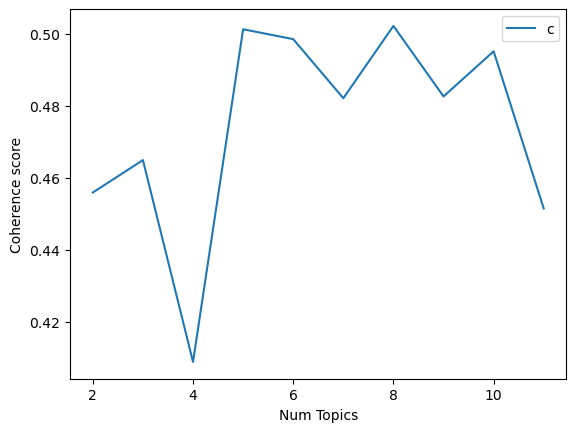

Num Topics = 2  has Coherence Value of 0.4559
Num Topics = 3  has Coherence Value of 0.4649
Num Topics = 4  has Coherence Value of 0.4089
Num Topics = 5  has Coherence Value of 0.5012
Num Topics = 6  has Coherence Value of 0.4985
Num Topics = 7  has Coherence Value of 0.4821
Num Topics = 8  has Coherence Value of 0.5021
Num Topics = 9  has Coherence Value of 0.4826
Num Topics = 10  has Coherence Value of 0.4951
Num Topics = 11  has Coherence Value of 0.4515


In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=gensim_corpus, texts=tokenized_lyrics, start=2, limit=12, step=1)

limit=12
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

As it can be seen, the number of topics maximizing the coherence score seems to be either 5 or 8. In the sollowing, the LDA algorithm was run so as to identify 8 topics. An attempt was also done with 5 topics but results were less precise and so, for this reason, the final algorithms includes 8 topics overall.

In [16]:
num_topics=8
lda_model = LdaModel(
corpus=gensim_corpus,
id2word=id2word,
chunksize=chunksize,
alpha='auto',
eta='auto',
iterations=iterations,
num_topics=num_topics,
passes=passes
)

The results have then been plotted so as to be able to visualize results:

In [27]:
vis_data = gensimvis.prepare(lda_model, gensim_corpus, dictionary)
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


From the above, the following topics were identified:

1: "People and Thoughts" (e.g., person, face, thought, moment, word)\
2: "Legal" (e.g., law, court, act, case, labour, part, right)\
3: "States/Feelings" (e.g., feel, well, ill, need)\
4: "Profanity and Violence" (e.g., sh\*t, b\*tch, f\*cking, mean, battle)\
5: "Body and Senses" (e.g., arm, foot, hand, look, face, watch, stand, voice)\
6: "Months and Food" (e.g., january, march, debruary, water, tea, bread)\
7: "People, Nature and the Unknown" (e.g., human, brain, memory, tree, forest, pet, spider, bug, secret, shadow, space, box, ancient, anomaly, nightmare)\
8: "Music and Rappers" (e.g., artist, vol, acoustic, creator, remix, playboi, carti, nudy, yachty, ski, styrke)

Now, to asses whether there was a difference or not between the topics of popular and non-popular songs, the most relevant topic for each song was calculated in the following chuncks of code. In particular, the most relevant topic for each song was calculated as the topic with the highest probability. (The corpus has been redefined just for extra safety, though it is not a mandatory step).

In [28]:
corpus = [dictionary.doc2bow(text) for text in tokenized_lyrics]
doc_topics = lda_model[corpus]
topics = [max(doc_topic, key=lambda x: x[1])[0]+1 for doc_topic in doc_topics]

In [29]:
Counter(topics)

Counter({7: 5935, 3: 544, 6: 183, 1: 88, 5: 216, 8: 67, 4: 229, 2: 65})

As it can be seen from the counter above, most of the songs belong, for their greatest part, to topic 7. Which makes sense since is the one about persons, nature and the unknown, which are very common subjects of songs worldwide.

Then, the distribution of topics was plotted for both popular and non popular songs. The threshold to distinguish popular and non popular songs was set to be 46% in popularity of the songs. This value was selected as it is approximately the mean of the popularity of the songs in the dataset excluding all the songs that have 0 as popularity. It was deemed appropriate to exclude the songs with zero popularity from the computation of the mean because of their great number and hence their great influence on the mean, which biases the results towards zero. 

In [82]:
train_df1[train_df1['popularity']>0]["popularity"].mean()

46.26232862696951

<AxesSubplot: ylabel='Count'>

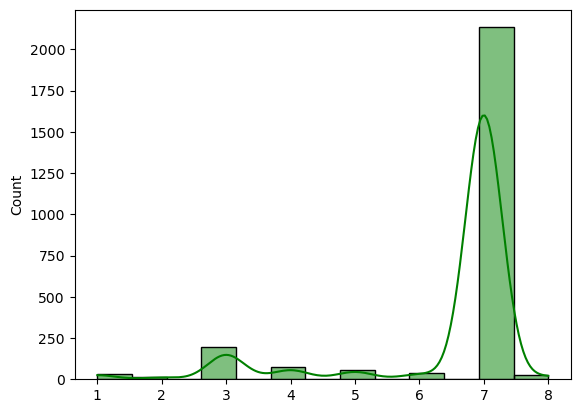

In [83]:
indeces = train_df1[train_df1["popularity"]>46].index
a=[]
for i in indeces:
    a.append(topics[i])
sns.histplot(a,color="green",kde=True)

<AxesSubplot: ylabel='Count'>

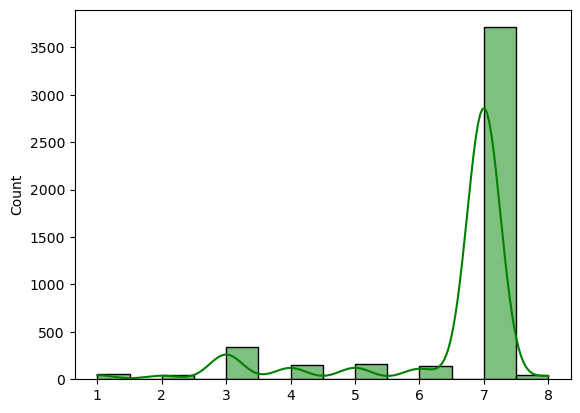

In [84]:
indeces = train_df1[train_df1["popularity"]<46].index
a=[]
for i in indeces:
    a.append(topics[i])
sns.histplot(a,color="green",kde=True)

As it can be seen form the plotetd histograms, there seems not to be any relevant difference. Indeed, the two distributions seem approximately the same. it is for this reason that it was decided to not pursue the analysis of the topic modelling for popular and non popular songs and hence not to include the results in the final dataframe. Given that the final goal is predicting whether a song will be popular or not based on previous evidence, there is no point in including an extra feature if this does not generate a distinction between the two groups. Given that this result was obtained for English lyrics, which represents the vast majority of the dataset, there was also no point in trying to perform the same analysis for the other languages, which likely would have not yielded different results. 

# Sentiment Analysis

Another attempt to discover significant differences between popular and non popular songs was to perform sentiment analysis on the lyrics. Indeed, the overall mood of the song can considered to be a good candidate to drive the distinction between popular and unpopular songs. Once again, only lyrics in English have been considered given that sentiment analysis algorithms/transformes are often language specific. As of before, the idea was to run sentiment analysis on songs in English (which are the vast majority of the songs in the dataset) and then, if a significant distiction was to be discovered, also perform the same steps on other languages.\
In order to conduct Sentiment Analysis, a first attempt was to use SentimentIntensityAnalyzer from the Nltk library. This is a rather simple pretrained sentiment analysis algorithm that returns a score for each of the three main sentiments (positive, negative and neutral) and a compound score that is the sum of the three scores. In particular, this algorithm was used to identify these scores, then the functions defined below, also creates a new column in the dataframe corresponding to the dominant sentiment. \
The results were then plotted in a piechart to be able to visualize the distribution of the sentiment scores across popular and non popular songs. The threshold to distinguish popular and non popular songs was, as for topic modelling, set to be 46%.

In [86]:
def setimentanalyzer(df):
    neg='Negative'
    neu='Neutral'
    pos='Positive'
    negative = []
    neutral = []
    positive = []
    dominant_sentiment=[]
    dominant_sentiment_score=[]
    sid = SentimentIntensityAnalyzer()
    for i in df.index:
       
        scores = sid.polarity_scores(' '.join(df['tokenized_lyrics'].iloc[i]))
        negative.append(scores['neg'])
        neutral.append(scores['neu'])
        positive.append(scores['pos'])
        if scores['neg']>scores['pos'] and scores['neg']>0.3:
            dominant_sentiment_score.append(scores['neg'])
            dominant_sentiment.append(neg)
        elif scores['neg']<scores['pos'] and scores['pos']>0.3:
            dominant_sentiment_score.append(scores['pos'])
            dominant_sentiment.append(pos)
        else:
            dominant_sentiment_score.append(scores['neu'])
            dominant_sentiment.append(neu)
    df['dominant_sentiment']=dominant_sentiment
    return df

The function was then applied to the dataframe under analysis:

In [91]:
df_fin=setimentanalyzer(train_df1)

And the piecharts were plotted starting from the one for popular songs:

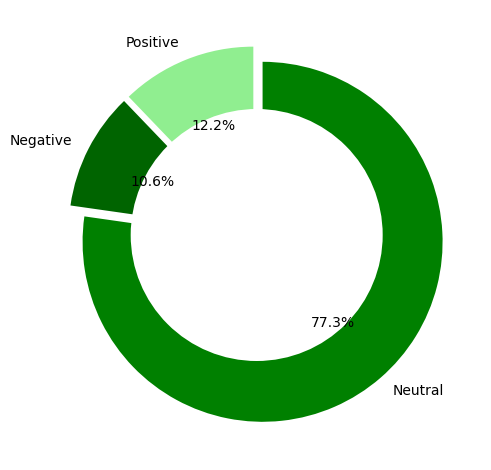

In [96]:
indeces = train_df1[train_df1["popularity"]>46].index
a=[]
for i in indeces:
    a.append(train_df1["dominant_sentiment"].iloc[i])
b=Counter(a)
plt.pie(b.values(),labels=b.keys(),autopct='%1.1f%%', startangle=90,colors=["lightgreen","darkgreen","green"],explode = (0.05,0.05,0.05))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

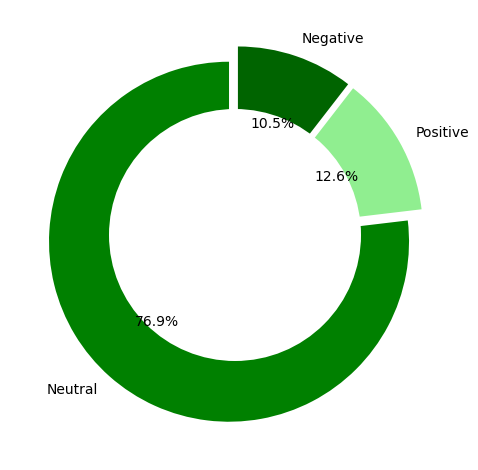

In [95]:
indeces = train_df1[train_df1["popularity"]<46].index
a_b=[]
for i in indeces:
    a_b.append(train_df1["dominant_sentiment"].iloc[i])
b_a=Counter(a_b)
plt.pie(b_a.values(),labels=b_a.keys(),autopct='%1.1f%%', startangle=90,colors=["green","lightgreen","darkgreen"],explode = (0.05,0.05,0.05))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

As it can be seen from the graphs above, once again there does not seem to be any statistically significant difference among popular and unpopular songs when it comes to classifying them according to positive/nuetral/negative sentiment. Indeed, the percentages are almost the same both for popular and unpopular songs.

At this point, given that the SentimentIntensityAnalyzer pretrained model from Ntlk is quite simple and is most suited for short texts, it was deemed appropriate to try to re-run the analysis with a more complicated model. Thus, an attempt was made with the DistilBert pretrained model from HugginFace. This model is a pretrained model that has been trained on a large corpus of text and that can be used to perform a variety of NLP tasks. In particular, this model can be used to perform sentiment analysis. The model was loaded and then applied to the lyrics of the songs. As before, results were then stored in a new column of the dataframe. The results (0 for "negative" songs and 1 for "positive" songs) were, as in the case of SentimentIntensityAnalyzer, plotted in a piechart to be able to visualize the distribution of the sentiment scores across popular and non popular songs. The threshold to distinguish popular and non popular songs was, as for topic modelling and SentimentIntensityAnalyzer, set to be 46%.\
Notice that in the code below the tokens previously created for the topic modelling were rejoined into a single string so as then to apply the specific tokenizer for the DistilBert model.

In [84]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

def analyze_sentiment(song_lyrics):
    inp = tokenizer(song_lyrics, padding=True, truncation=True, return_tensors="pt")
    out = model(**inp)
    aux, predicted_label = torch.max(out[0], dim=1)
    return predicted_label.item()

sentiments = []
for lyric in train_df1['tokenized_lyrics']:
    song_lyrics = ' '.join(lyric)
    sentiment_label = analyze_sentiment(song_lyrics)
    sentiments.append(sentiment_label)

train_df1['sentiment_label'] = sentiments

/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/3112795052.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1['sentiment_label'] = sentiment_labels


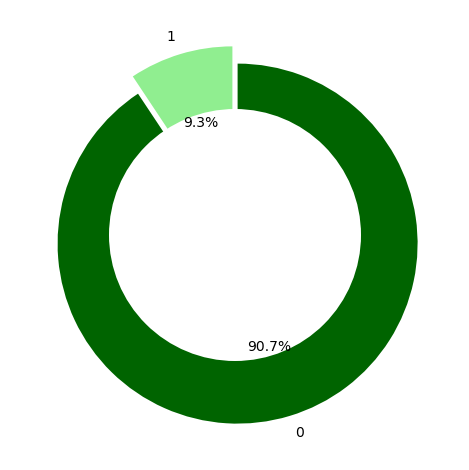

In [86]:
indeces = train_df1[train_df1["popularity"]>46].index
a=[]
for i in indeces:
    a.append(train_df1["sentiment_label"].iloc[i])
b=Counter(a)
plt.pie(b.values(),labels=b.keys(),autopct='%1.1f%%', startangle=90,colors=["lightgreen","darkgreen"],explode = (0.05,0.05))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

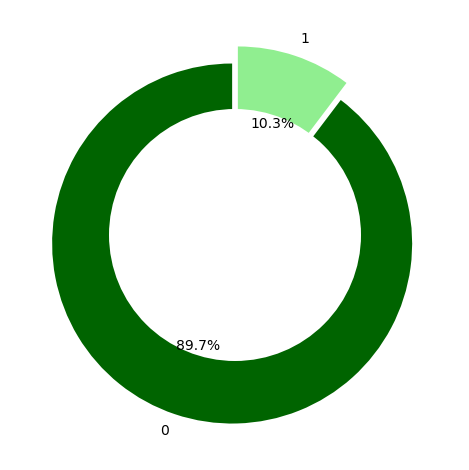

In [89]:
indeces = train_df1[train_df1["popularity"]<46].index
a_b=[]
for i in indeces:
    a_b.append(train_df1["sentiment_label"].iloc[i])
b_a=Counter(a_b)
plt.pie(b_a.values(),labels=b_a.keys(),autopct='%1.1f%%', startangle=90,colors=["darkgreen","lightgreen"],explode = (0.05,0.05))
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()

As it can be seen from the graphs above, once again there does not seem to be any statistically significant difference among popular and unpopular songs when it comes to classifying them according to positive/negative sentiment.\
It is for this reason that, following the same logic as the one used for topic modelling, it was decided not to include the sentiment analysis results in the final dataframe. As a matter of fact, the results of the sentiment analysis do not seem to be able to distinguish between popular and unpopular songs. Logically, this can also make sense. Indeed, very popular songs as well as non popular songs exist for all these three possible sentiments. Being that the distributions are equal, it would not be meaningful to use the sentiment analysis results to predict whether a song will be popular or not.

# Actual Analysis

### Data pre-processing and feature engineering

At this point, given that the analysis of the lyrics did not yield any significant difference between popular and non popular songs, the analysis was focused on the other features of the dataset. In particular, to begin with, the old database containing all the songs in all the languages has been loaded:

In [73]:
songs_df = pd.read_csv("final.csv")

In [74]:
songs_df.rename(columns={"title": "name", "artist_id": "id_artists"}, inplace= True)

Then, some dictiories were created. In particular, dictionaries matching artists woth their popularity, followers and genres were created:

In [75]:
artist_popularity_dic = dict(zip(artist_df["id"], artist_df["popularity"]))
artist_followers_dic = dict(zip(artist_df["id"], artist_df["followers"]))

In [76]:
genre_dic = defaultdict(list)
id_genre_dic = dict()

for i, row in artist_df.iterrows():
    genre_list = str(row["genres"]).replace("[", "").replace("]","").replace("'", "").split()
    for entry in genre_list:
        genre_dic[entry].append(row["popularity"])
    id_genre_dic[row["id"]] = genre_list

Lists containing the highest occuring genres as well as the most popular ones have also been created:

In [77]:
genre_counts = sorted([(p, len(genre_dic[p])) for p in genre_dic], key=lambda x:x[1], reverse=True)
valid_genres = [g[0] for g in genre_counts[0:1000]]
top_genres = [g[0] for g in genre_counts[0:200]]
popularity_sorted = sorted([(p, np.mean(genre_dic[p])) for p in genre_dic if p in valid_genres], key=lambda x:x[1], reverse=True)
popular_genres = [p[0] for p in popularity_sorted[0:200]]

Since many of the songs are features or collaborations, it was deemed useful to compute the mean and max for popularity and followers of all artists involved in each song:

In [ ]:
songs_df["artist_list"] = songs_df["id_artists"].map(lambda x: str(x).replace("[", "").replace("]","").replace("'", "").split())

for i, row in songs_df.iterrows():
    mod_string = row["artist_list"]
    if len(row["artist_list"])>1:
        l=[]
        t=0
        for element in row["artist_list"]:
            if t==len(row["artist_list"])-1:
                l.append(row["artist_list"][len(row["artist_list"])-1])
                break
            size = len(row["artist_list"][t])
            mod_string = element[:size - 1]
            l.append(mod_string)
            t+=1
        songs_df.at[i,'artist_list'] = l

Two functions to calculate the popularity and the followers for each artist were then defined. These function will be then applied to the artist list column so as to obtain the required new features for the dataframe for further analysis.

In [78]:
def calc_popularity_for_artist(id_list, flag):
    popularity_scores = list()
    for entry in id_list:
        if entry in artist_popularity_dic:
            popularity_scores.append(artist_popularity_dic[entry])
        else:
            popularity_scores.append(0)
    if flag == "max":
        return max(popularity_scores)
    else:
        return np.mean(popularity_scores)

In [79]:
def calc_followers_for_artist(id_list, flag):
    follower_scores = list()
    for entry in id_list:
        if entry in artist_followers_dic:
            follower_scores.append(artist_followers_dic[entry])
        else:
            follower_scores.append(0)
    if flag == "max":
        return max(follower_scores)
    else:
        return np.mean(follower_scores)

In [ ]:
songs_df["feature_max_artist_popularity"] = songs_df["artist_list"].map(lambda x: calc_popularity_for_artist(x, flag="max"))
songs_df["feature_mean_artist_popularity"] = songs_df["artist_list"].map(lambda x: calc_popularity_for_artist(x, flag="mean"))

In [81]:
songs_df["feature_max_artist_followers"] = songs_df["artist_list"].map(lambda x: calc_followers_for_artist(x, flag="max"))
songs_df["feature_mean_artist_followers"] = songs_df["artist_list"].map(lambda x: calc_followers_for_artist(x, flag="mean"))

A function was then created to map genres to each of the songs. In particular, the genres associated to all the artists involved in the song will be associated to each individual song. Moroever, some flags will be used. In particular, valid genres indicate genres applicable to the song, top genres are the ones occurring with highest frequency, and popular genres are the ones associated with the most popular songs.

In [82]:
def map_genres(id_list, flag):
    genres = list()
    for entry in id_list:
        if entry in id_genre_dic:
            if flag == "valid":
                genres += [i for i in id_genre_dic[entry] if i in valid_genres]
            elif flag == "popular":
                genres += [i for i in id_genre_dic[entry] if i in popular_genres]
            else:
                genres += [i for i in id_genre_dic[entry] if i in top_genres]
    genres = list(set(genres))
    if len(genres) > 0:
        return "_".join(sorted(genres))
    else:
        return None

In [83]:
songs_df["genre_flag_valid"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="valid"))
songs_df["genre_flag_top"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="top"))
songs_df["genre_flag_popular"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="popular"))

Then, the id of the artists were stripped from the square brackets and then split:

In [84]:
songs_df['id_artists'] = songs_df['id_artists'].str.strip('[]').str.split(',')

And a new dataframe was created with this new information:

In [85]:
df = pd.DataFrame(songs_df['id_artists'].values.tolist()).add_prefix('artist_')

In [86]:
songs_df = pd.merge(songs_df, df['artist_0'], left_index=True, right_index=True)

Then, the artists and songs dataframes were merged:

In [87]:
train_df = songs_df.merge(artist_df,left_on=['artist_0'],right_on=['id'],how='inner')

Then, the duration was transform from millisecond to minutes:

In [88]:
train_df['duration_ms'] = train_df['duration_ms']/1000/60

In [89]:
train_df.rename(columns={"duration_ms": "duration", "popularity_x": "popularity_song","popularity_y":"popularity_artist"}, inplace=True)

And the genres were split:

In [90]:
train_df['genres'] = train_df['genres'].str.split(',')

In [91]:
train_df['genres'] = train_df['genres'].apply(lambda d: d if isinstance(d, list) else [])

And a new genres dataframe was created with this new information and then merged to the existing training dataframe:

In [92]:
df = pd.DataFrame(train_df['genres'].values.tolist()).add_prefix('genre_')

In [93]:
train_df = pd.merge(train_df, df, left_index=True, right_index=True)

Then, it was deemed appropriate to create a dummy variable for the most important genres, clearly the dum,my would be 1 if the song is associated with the genre and 0 otherwise. The code used was the following:

In [94]:
cols=[]
for i in range(15):
    cols.append(f"genre_{i}")
train_df["all"] = train_df[cols].apply(lambda x: ','.join(x.dropna()), axis=1)
train_df['all'] = train_df['all'].str.split(',')

In [106]:
genres = ["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul"]
train_df1 = train_df.copy()
for g in genres:
    train_df[g] = 0
    i=0
    for index,row in train_df1.iterrows():
        print(i)
        i+=1
        t = False
        nn=len(row["all"])
        end=19+nn
        for col in train_df1.iloc[:,34:49]:
            if g is not None and isinstance(row[col], str):
                one = g.split()
                two = row[col].split()
                common = set(one).intersection(set(two))
                unique = set(one).symmetric_difference(set(two))
            if len(common)>0:
                t = True
        if t == True:
            train_df1.loc[index, g ] = 1

Output streaming troncato alle ultime 5000 righe.
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826
5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837
5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854
5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866
5867
5868
5869
5870
5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894


In [107]:
train_df1[["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul", 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers']] = train_df1[["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul", 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers']].fillna(0).astype(int)

Now that the dummy about the genres has been created, it is posisble to proceed with the dropping of the genres columns as well as of other columns with no information of use (e.g., the id and the name of the artist are of no use given that the popularity and the followers of the artist are known, indeed these are the main characteristics that are likely to differentiate among popular and non popular songs and tell much more about an artist than its name per se). 

In [110]:
for i in range(15):
    train_df1.drop(columns = [f"genre_{i}"], inplace = True)
train_df1.drop (columns = ["name", "id_artists", "id_x", "genres", "artist_0", "all"], inplace = True)

In [114]:
train_df1.drop(['album_name', 'album_id','artist_list','genre_flag_valid'],axis=1,inplace=True)

Then, it was also deemed appropriate to create a dummy variable, building upon the genres' flags created above, to indicate whether the particular song under analysis belongs or not to the top genres and/or belongs to the popular genres. The code to do so is as follows:

In [111]:
train_df1["genre_flag_top"]=[0 if x is None else 1 for x in train_df1["genre_flag_top"]]

In [112]:
train_df1["genre_flag_popular"]=[0 if x is None else 1 for x in train_df1["genre_flag_popular"]]

Then, some preprocessing for what concerns the date of the songs' release was performed. In particular, the date was formatted with the to_datetime function of pandas and then the weekday and the month were extracted. Indeed, realising songs on a particular day of the week or month might impact their popularity significantly.

In [253]:
train_df1['release_date_format'] = pd.to_datetime(train_df1['release_date'], errors='coerce')

In [255]:
train_df1['weekday'] = train_df1['release_date_format'].dt.dayofweek

In [256]:
train_df1 = train_df1.join(train_df1['release_date'].str.split('-', expand=True).rename(columns={0:'release_year', 1:'release_month', 2:'release_day'}))

In [257]:
train_df1["release_month"] = train_df1["release_month"].astype("float")

Then, superflous columns were dropped (notice that the year has been dropped since it was deemed less relevant that the day of the week and the month of the release, as a matter of fact the task is predicting future popularity and not past popularity, hence having, for instance, the informtion that songs released in 2010 are more popular than those published in 2009 does not provide actionable insights for record labels):

In [258]:
train_df1.drop(['release_date', 'release_year','release_day','release_date_format','id_y'], axis=1, inplace = True)

Then, **One-Hot Encoding** was applied to the categorical variables of the dataframe so that they can be used in the machine learning models. In particular, the categorical variables transformed are the following: the day of the week and the month. The record label was left as an object and not included in the One-Hot encoding as in the dataset there are more than 1600 record labels and, hence, creating a dummy variable for each of them would have resulted in a very sparse dataframe. This would have made the training of the models very slow and would have also made the models less precise with high probability. 

In [259]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
columns_encoded=OH_encoder.fit_transform(train_df1[['release_month','weekday']])

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Thenm the new encoded columns were transformed into a dataframe and merged to the training dataframe:

In [260]:
columns_encoded = pd.DataFrame(columns_encoded, columns=OH_encoder.get_feature_names_out(['release_month','weekday']))

In [261]:
train_df1=pd.merge(train_df1,columns_encoded,left_index=True,right_index=True)

And the old, not encoded, versions of the variables were dropped:

In [262]:
train_df1.drop("release_month", axis=1, inplace=True)

In [263]:
train_df1.drop("weekday", axis=1, inplace=True)

Then, as a checkpoint, the resulting dataframe was saved as a csv file:

In [274]:
train_df1.to_csv('final4 (1).csv', index=False)

### Artists analysis

In [125]:
train_df1 = pd.read_csv("final4 (1).csv")

Now, a closer look at three very important artists have been taken. In particular, Meghan Trainor, Ariana Grande, and Taylor Swift were analysed more in detail to understand if there are some distinguishable patterns that differentiate their popular songs from their non popular ones. 

#### Meghan Trainor

A sub-dataframe containing only songs by Meghan Trainor was created (notice that only the songs in which the artist was singing alone were considered, indeed havig a feature or a collaboration with another artist might have impacted the popularity of the song beyond the artist's popularity and hence bias results):

In [126]:
indices=train_df1[train_df1["all_artists"]=="[Meghan Trainor]"].index

In [127]:
Meghan=train_df1.loc[indices]

Once again, songs were splitt into popular and non popular as was done for topic modelling and sentiment analysis so as to be able to detect any difference, if present. This time, the threshold used was 45% as the mean popularity of the songs in the dataframe (as before excluding all those songs with 0 popularity) was approximately 45%:

In [128]:
train_df1[train_df1['popularity_song']>0]["popularity_song"].mean()

45.44525038359604

In [129]:
Meghan.loc[(Meghan['popularity_song'] > 45), 'popular'] = 'Y'
Meghan['popular'] = Meghan['popular'].fillna('N')

In [130]:
Meghan.reset_index(inplace=True,drop=True)

Then, indices of popular and non popular songs were obtained:

In [131]:
indices_pop = Meghan[Meghan["popular"]=="Y"].index
indices_nonpop = Meghan[Meghan["popular"]=="N"].index

And non numeric features were dropped so as to be able to run a Pricipal Component Analysis (PCA) on the sub-dataframe to try and detect what are the most relevant dimensions to be considered. More in depth, Principal Component Analysis is an unsupervised learning technique that helps in finding a sequence of linear combinations of variables so as to be able to increases interpretability yet, at the same time, minimizing information loss. This last point is achieved by preserving maximum variation. As a matter of fact, dimensions on which more variation is included are likely those that carry most of the information that can possibly lead to the distiction between popular and non popular songs. 

In [132]:
Meghan_numeric=Meghan.drop(["record_label", "popular"],axis=1)

In [133]:
pca = PCA(n_components=2)
features_pca =pca.fit_transform(Meghan_numeric.iloc[:,4:])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.9790061 0.0163422]
[274.40022018  35.4525166 ]


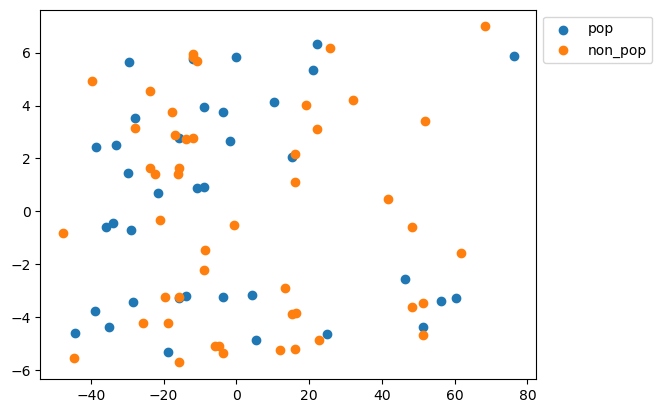

In [134]:
plt.scatter(features_pca[indices_pop,0], features_pca[indices_pop,1])
plt.scatter(features_pca[indices_nonpop,0], features_pca[indices_nonpop,1])
plt.legend(["pop" , "non_pop"], bbox_to_anchor = (1 , 1))

From the plotting of the songs after applying PCA, it is possible to see that no clear separation between popular and non-popular songs is distinguishable. This is a hint that, in classifying songs as popular or non-popular, a linear classification boundary is likely not ideal, even though this might change in a higher dimensionality space.
In particular, though, it is possible to see that the top 3 features along which more variance is associated are, for the first component, respectively the dummy about the genre trap, the number of followers and the popularity of the artist:

In [135]:
np.argsort(abs(pca.components_[0]))[0:3]

array([25, 21, 22])

In [137]:
train_df1.iloc[:,25]

0        0
1        0
2        0
3        0
4        0
        ..
10700    0
10701    0
10702    0
10703    0
10704    0
Name: trap, Length: 10705, dtype: int64

In [136]:
train_df1.iloc[:,21]

0        13157348
1        13157348
2        13157348
3        13157348
4        13157348
           ...   
10700      207035
10701        7935
10702         367
10703      394759
10704      940933
Name: followers, Length: 10705, dtype: int64

In [138]:
train_df1.iloc[:,22]

0        82
1        82
2        82
3        82
4        82
         ..
10700    50
10701    21
10702    15
10703    58
10704    61
Name: popularity_artist, Length: 10705, dtype: int64

#### Ariana Grande


The exact same procedures were then carried out also for Ariana Grande:

In [139]:
indices=train_df1[train_df1["all_artists"]=="[Ariana Grande]"].index

In [140]:
Ariana=train_df1.loc[indices]

In [141]:
Ariana.loc[(Ariana['popularity_song'] > 45), 'popular'] = 'Y'
Ariana['popular'] = Ariana['popular'].fillna('N')

In [142]:
Ariana.reset_index(drop=True, inplace=True)

In [143]:
indices_pop = Ariana[Ariana["popular"]=="Y"].index
indices_nonpop = Ariana[Ariana["popular"]=="N"].index

In [144]:
Ariana_numeric=Ariana.drop(["record_label", "popular"],axis=1)

In [145]:
pca = PCA(n_components=2)
features_pca =pca.fit_transform(Ariana_numeric.iloc[:,4:])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.97103481 0.01556378]
[313.03210471  39.63045423]


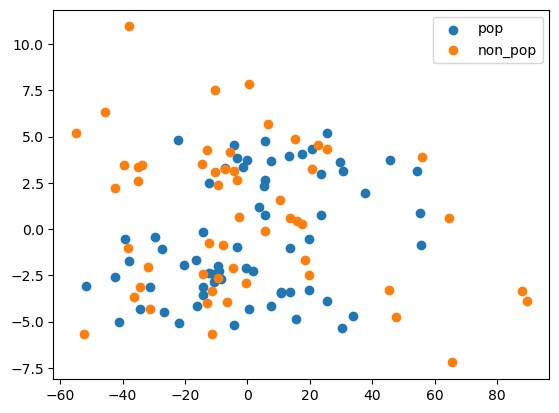

In [146]:
plt.scatter(features_pca[indices_pop,0], features_pca[indices_pop,1])
plt.scatter(features_pca[indices_nonpop,0], features_pca[indices_nonpop,1])
plt.legend(["pop" , "non_pop"], bbox_to_anchor = (1 , 1))

Here, the same reasoning conducted for Meghan Trainor can be applied. In particular, it is possible to see that the top 3 features along which more variance is associated are, for the first component, once again respectively the dummy about the genre trap, the number of followers and the popularity of the artist:

In [147]:
np.argsort(abs(pca.components_[0]))[0:3]

array([25, 21, 22])

#### Taylor Swift

Once again, also for Taylor Swift, the same procedures were carried out:

In [148]:
indices=train_df1[train_df1["all_artists"]=="[Taylor Swift]"].index

In [149]:
Taylor=train_df1.loc[indices]

In [150]:
Taylor.loc[(Taylor['popularity_song'] > 45), 'popular'] = 'Y'
Taylor['popular'] = Taylor['popular'].fillna('N')

In [151]:
Taylor.reset_index(drop=True, inplace=True)

In [152]:
indices_pop = Taylor[Taylor["popular"]=="Y"].index
indices_nonpop = Taylor[Taylor["popular"]=="N"].index

In [153]:
Taylor_numeric=Taylor.drop(["record_label", "popular"],axis=1)

In [154]:
pca = PCA(n_components=2)
features_pca =pca.fit_transform(Taylor_numeric.iloc[:,4:])
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.97821204 0.01215359]
[405.72163578  45.22348571]


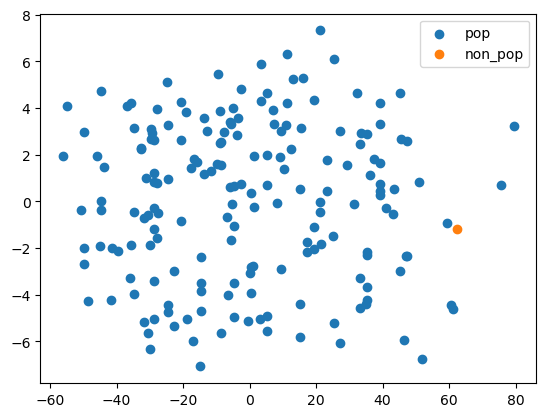

In [155]:
plt.scatter(features_pca[indices_pop,0], features_pca[indices_pop,1])
plt.scatter(features_pca[indices_nonpop,0], features_pca[indices_nonpop,1])
plt.legend(["pop" , "non_pop"], bbox_to_anchor = (1 , 1))

By the looks of this graphs, it seems that Taylor Swift has just one non popular song, thus probably it is not the best choice for the artist to identify significant distinguishing factors. Still, the top 3 features along which more variance is associated can be obtained as before and these are:

In [156]:
np.argsort(abs(pca.components_[0]))[0:3]

array([25, 19, 20])

In [157]:
train_df1.iloc[:,25]

0        0
1        0
2        0
3        0
4        0
        ..
10700    0
10701    0
10702    0
10703    0
10704    0
Name: trap, Length: 10705, dtype: int64

In [158]:
train_df1.iloc[:,19]

0        1
1        1
2        1
3        1
4        1
        ..
10700    1
10701    1
10702    1
10703    1
10704    1
Name: genre_flag_top, Length: 10705, dtype: int64

In [159]:
train_df1.iloc[:,20]

0        1
1        1
2        1
3        1
4        1
        ..
10700    1
10701    1
10702    0
10703    0
10704    1
Name: genre_flag_popular, Length: 10705, dtype: int64

# Exploratory data analysis and more feature engineering

At this point, before running the final models, some visualizations and data exploration analysis were carried out.\
To begin with, the relationship between the popularity of the song, the popularity of the artist, and technical charactiristics of the songs was explored via the usage of a pairplot:

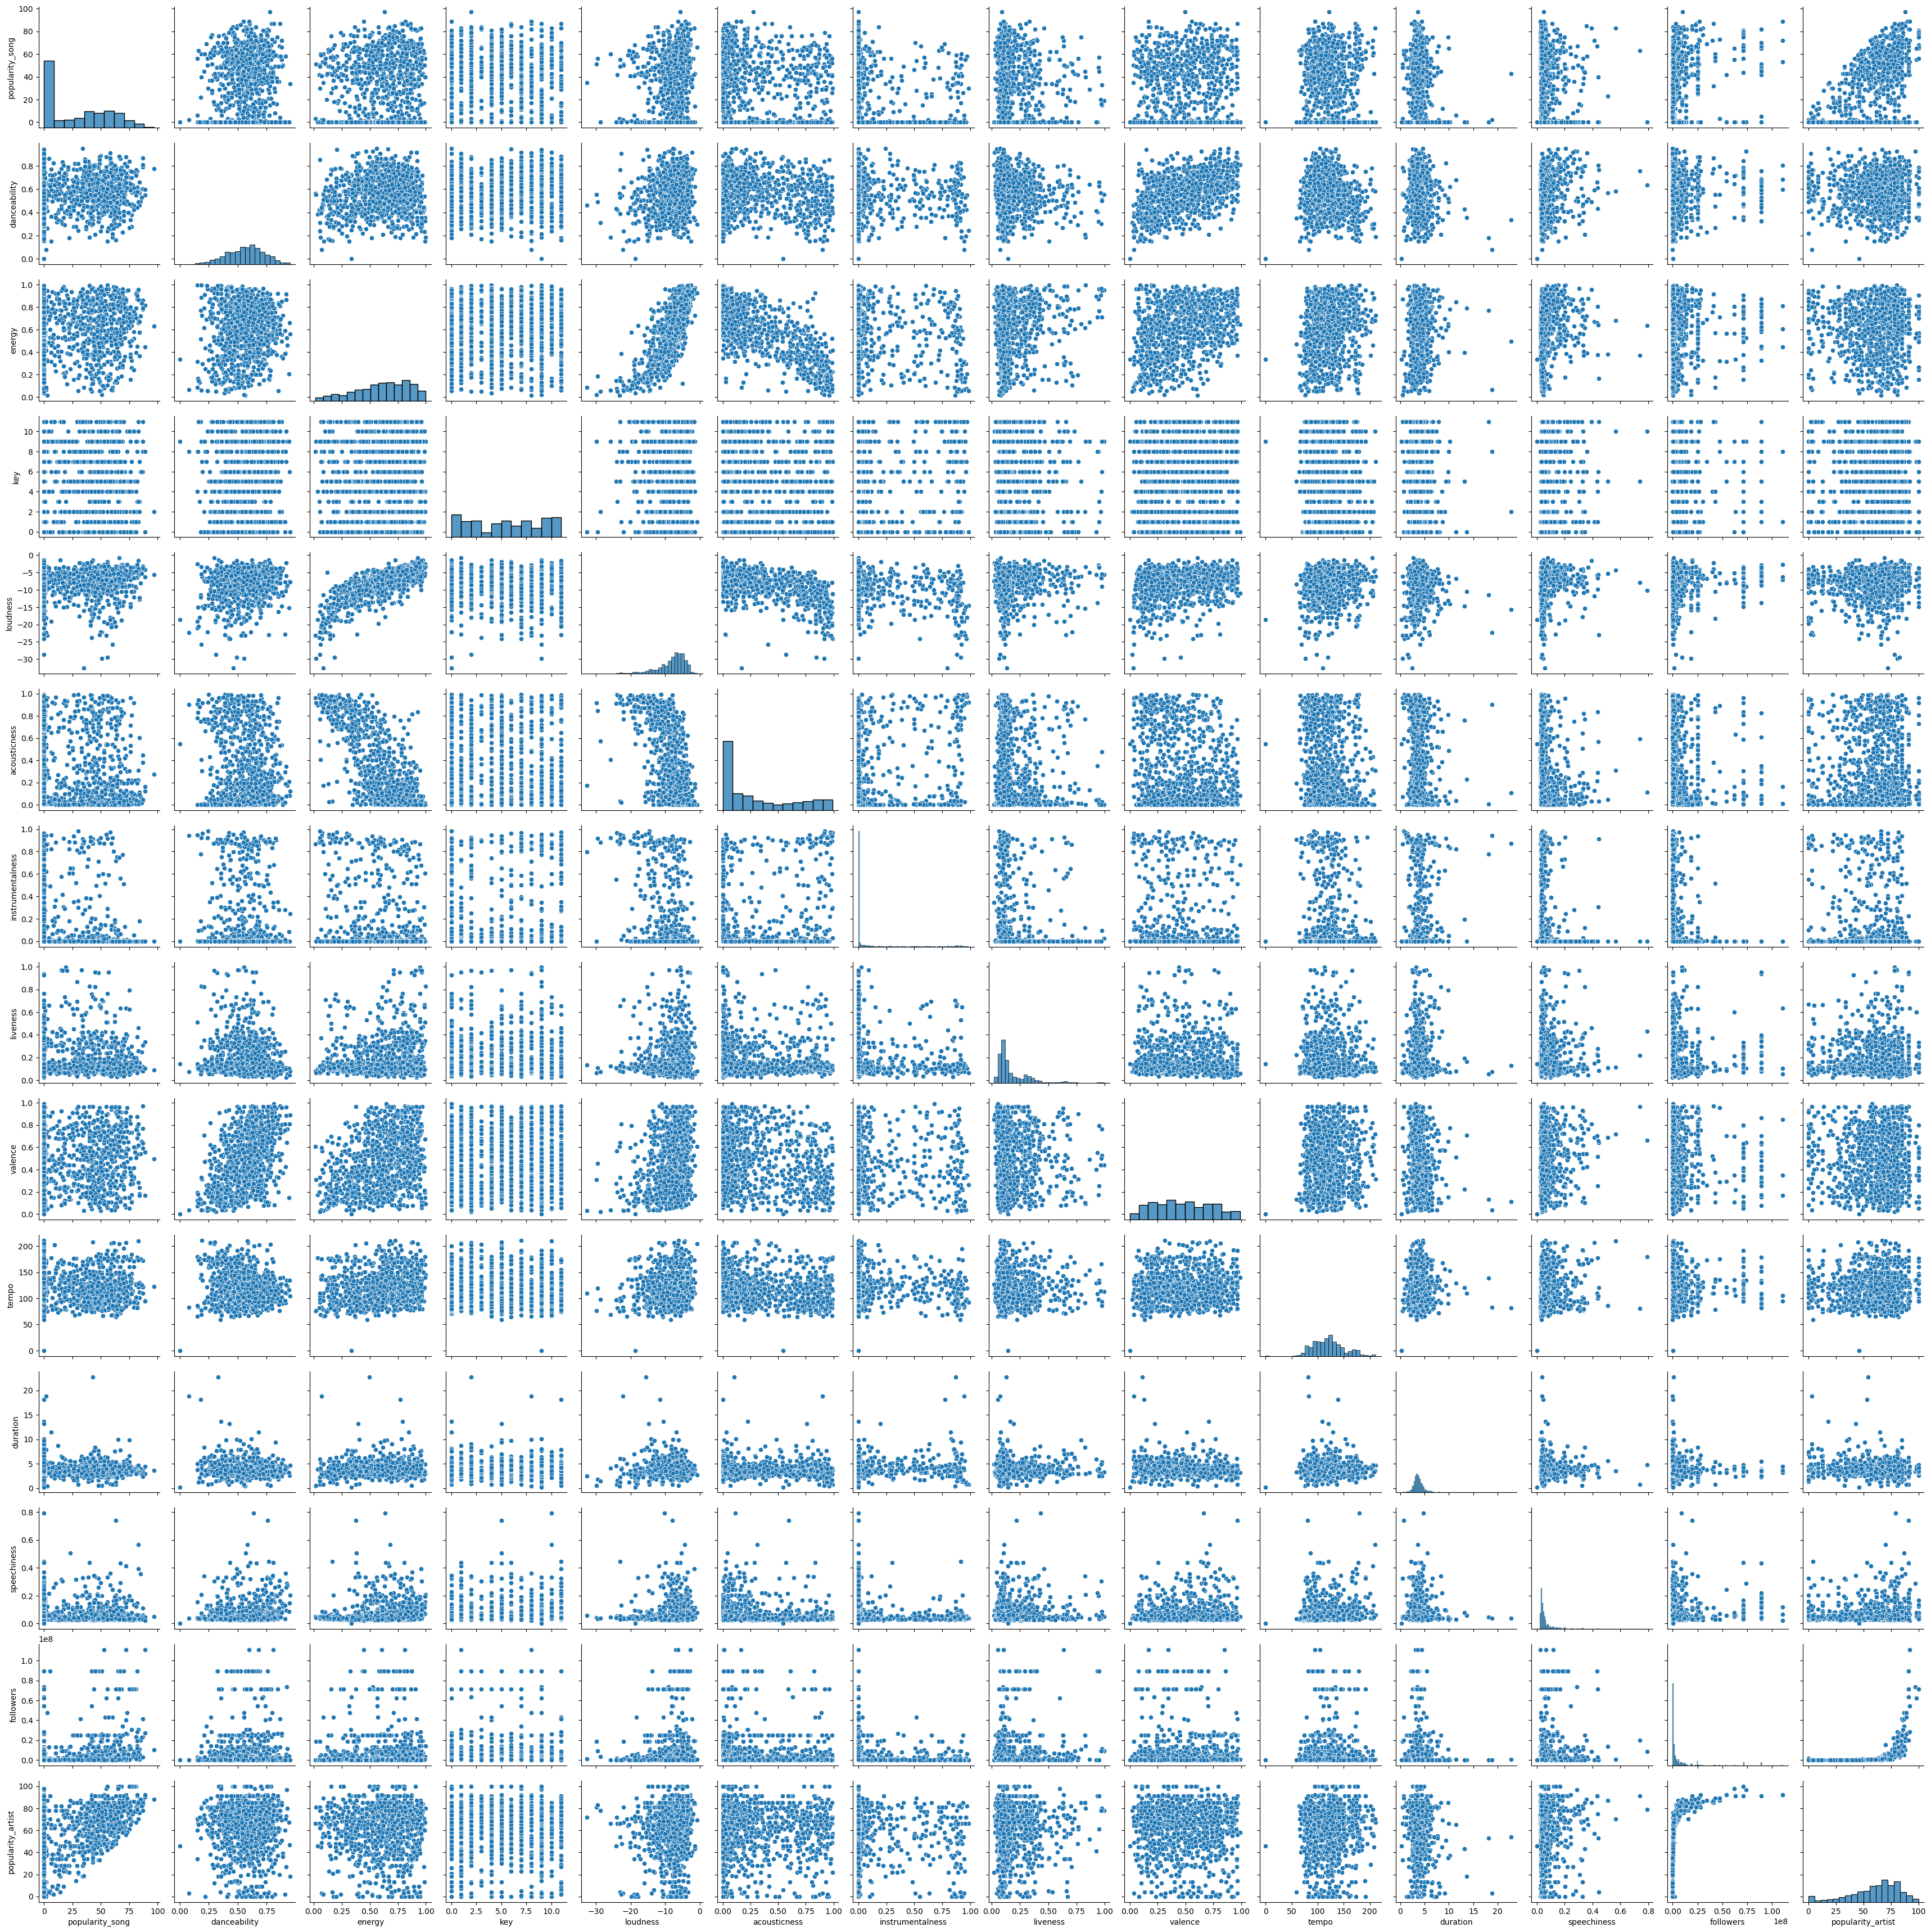

In [125]:
sampled_data = train_df1.sample(n=1000, random_state=42)
sns.pairplot(sampled_data[['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'followers', 'popularity_artist']])

From this, and in particular from the histograms on the diagonal, it can be seen that some variables are right skewed. This could potentially be a concern for certain types of models that are not robust to skewedness of data. So as to mitigate this issue, the logarithm of the variables was taken. Indeed, among the usual techniques to deal with skewedness (another one is for example taking the square root), the logarithm is the one that was found to work best on the available data.

In [93]:
train_df1["log_duration"] = train_df1["duration"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_speechiness"] = train_df1["speechiness"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_instrumentalness"] = train_df1["instrumentalness"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_liveness"] = train_df1["liveness"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_followers"] = train_df1["followers"].map(lambda x: np.log(x) if x > 0 else 0)

Then, the boxplots of the technical features of the songs were plotted as a way to check for the presence of outliers, which might, once again, negatively impact the performance of certain models:

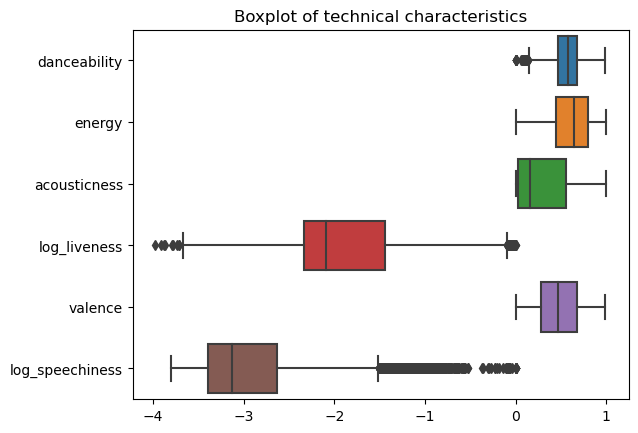

In [127]:
cols = ['danceability', 'energy', 'acousticness', 'log_liveness', 'valence',  'log_speechiness']
sns.boxplot(data=train_df1[cols], orient="h")
plt.title('Boxplot of technical characteristics')
plt.show()

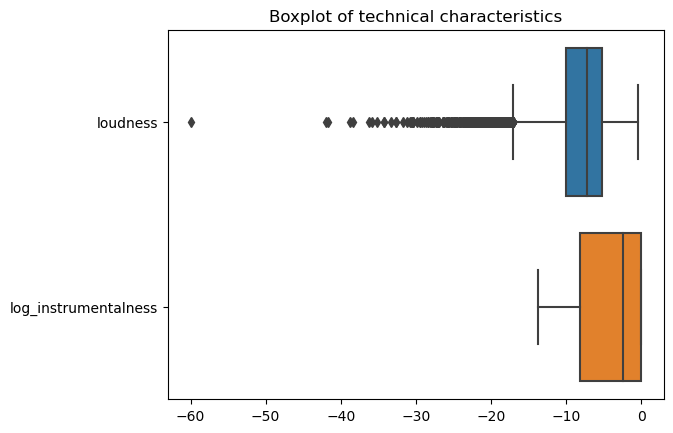

In [128]:
cols = ['loudness','log_instrumentalness']
sns.boxplot(data=train_df1[cols], orient="h")
plt.title('Boxplot of technical characteristics')
plt.show()

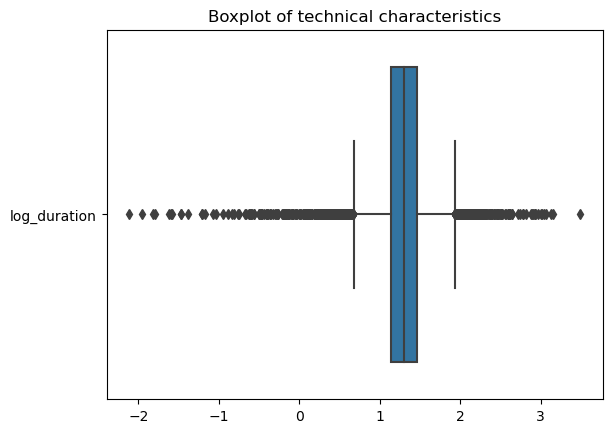

In [129]:
cols = ['log_duration']
sns.boxplot(data=train_df1[cols], orient="h")
plt.title('Boxplot of technical characteristics')
plt.show()

As it can be seen, there seems to be some outliers in the log_duration, log_speechiness, and loudness variables. However, since the outliers are not unrealistic values, they will not be removed from the dataset for the time being. If then some particular model will show to be particularly sensitive to outliers, the outliers will be removed and the model will be retrained.

Then, the key of the song was analysed and plotted against the popularity of the song:

In [48]:
train_df1['key'] = train_df1['key'].astype(str)

<AxesSubplot: xlabel='key', ylabel='popularity_song'>

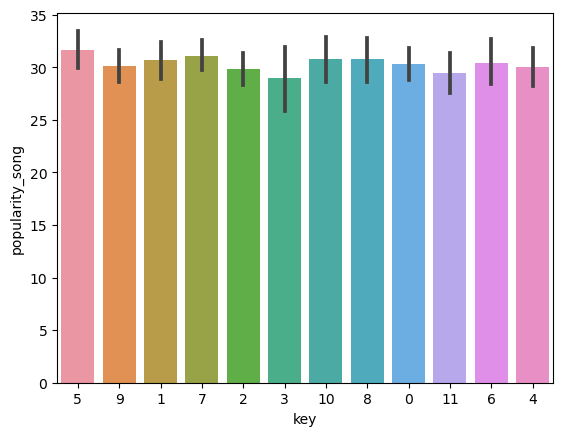

In [131]:
sns.barplot(x = 'key', y = 'popularity_song', data = train_df1)

As it can be seen, there seems not to be a great difference in the popularity of the songs depending on the key.

Then, the correlations of the features with the variable of interest were obtained. Correlation indeed might be a sign of what are the variables that are more likely to impact the popularity of the song. It has though to be remembered that, in general, correlation does NOT imply causation. Still this could be an interesting starting point and several useful informations can be deduced. 

In [132]:
train_df1.corrwith(train_df1['popularity_song']).sort_values(ascending=False)

popularity_song                   1.000000
feature_mean_artist_popularity    0.413660
feature_max_artist_popularity     0.409658
popularity_artist                 0.408765
log_followers                     0.381261
feature_mean_artist_followers     0.279155
followers                         0.272519
feature_max_artist_followers      0.269953
weekday_4.0                       0.135113
genre_flag_popular                0.128454
loudness                          0.097980
rap                               0.075915
danceability                      0.068663
valence                           0.057262
r&b                               0.051468
jazz                              0.039494
latin                             0.035570
energy                            0.033126
soul                              0.029752
release_month_7.0                 0.019789
release_month_11.0                0.017674
release_month_3.0                 0.017367
weekday_5.0                       0.017095
release_mon

From this, it seems that indicators of popularity of the artists involved in the songs are very correlated with the final popularity of the song, which also makes sense logically. Moreover, instrumentalness seems to be the varibale with the lowest correlation, even a negative one. This might also make sense since , in general, songs with lyrics are more popular than instrumental ones. \
Now, the correlation matrix has been plotted for the variables that risk to be highly correlated withing each other. As a matter of fact, high correlation within variables might severely impact the performance of some models, one amongst them is linear regression. 


<AxesSubplot: >

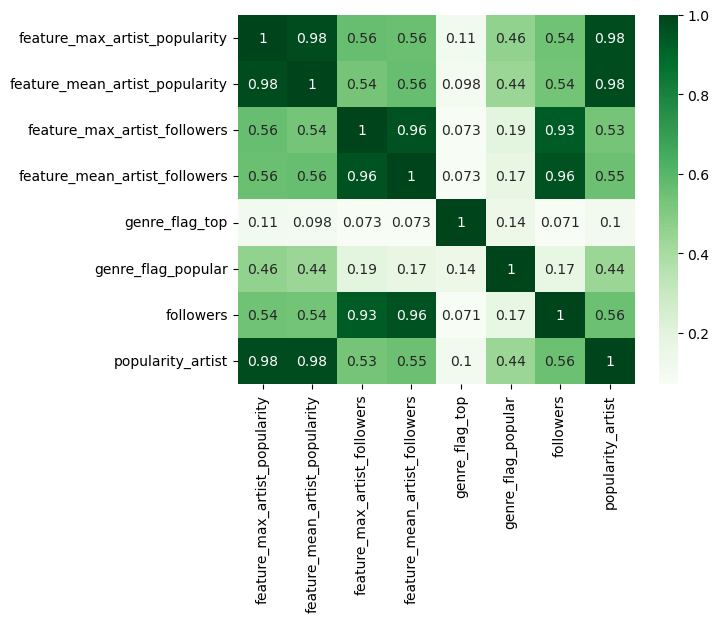

In [98]:
corr_matrix = train_df1[['feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'genre_flag_top', 'genre_flag_popular',
       'followers', 'popularity_artist']].corr()
sns.heatmap(corr_matrix, annot=True,cmap="Greens")

Clearly, there is a very high correlation between an artist popularity and the max and mean popularity of the artists included in the song. This was highly foreseable and will surely be taken under consideration when applying models.\
The correlation between days of the week and months of the year was also explored (also the overall popularity of the song was included in this case to get extra information): 

<AxesSubplot: >

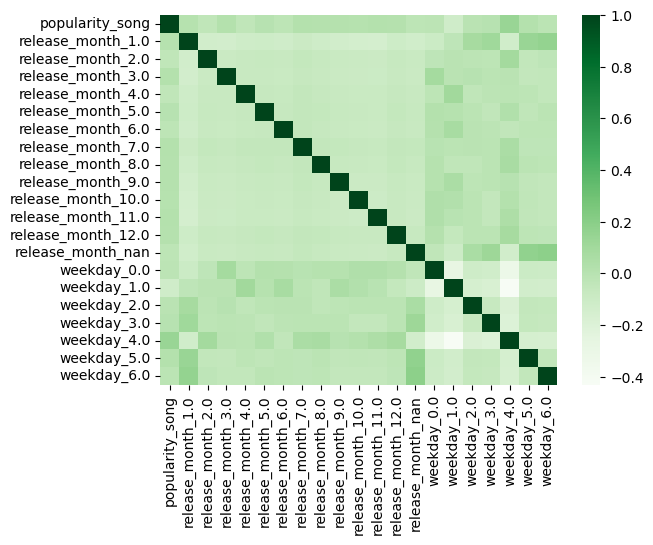

In [100]:
corr_matrix = train_df1[['popularity_song','release_month_1.0', 'release_month_2.0',
       'release_month_3.0', 'release_month_4.0', 'release_month_5.0',
       'release_month_6.0', 'release_month_7.0', 'release_month_8.0',
       'release_month_9.0', 'release_month_10.0', 'release_month_11.0',
       'release_month_12.0', 'release_month_nan', 'weekday_0.0', 'weekday_1.0',
       'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0',
       'weekday_6.0']].corr()
sns.heatmap(corr_matrix,cmap="Greens")

In this case, there seems not to be any issue concerning multicollinearity.

# Models

After having conducted some exploratory data analysis and some more feature engineering, some machine learning models were applied to actually predict the popularity of songs and effectively answer the reasearch question that has guided this whole analysis. In particular, the problem was addressed both from a regression and from a classification perspective.  

### Regression Perspective

To begin with, the problem was addressed from a regression perspective. Hence, an attampt was made in predicting exactly the popularity of the song. To this end, after having performed a train test split and a Standard Scaling (which is not required for every model, indeed some of them are insensitive to the scale of the data, but still is for some others), different machine learning models were tested so as to identify the one working best on the avalilable data. It has to be noted how the few categorical features that were still present in the dataframe (e.g., the record label) were excluded from this part of the analysis as the following algorithms are not able to deal with categorical features. They were then included when an attempt was done with the CatBoost algorithm. Though, results were worst, even after a cross validated grid search, than the ones of the best performing regression algorithm included below and, hence, it was not included in the final analysis. More specifically, to evaluate the results, both the Root Mean Squared Error and the R-squared were used. The RMSE, in particular, represents the square root of the second sample moment of the differences between predicted values and observed values. While the R-squared (coefficient of determination) is the proportion of the variation in the dependent variable that is predictable from the independent variables.

In [6]:
X = train_df1[[ 'danceability', 'energy', 'loudness',
       'acousticness', 'valence', 'tempo',
       'feature_max_artist_popularity', 'feature_mean_artist_popularity',
       'feature_max_artist_followers', 'feature_mean_artist_followers',
       'genre_flag_top', 'genre_flag_popular',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'release_month_1.0', 'release_month_2.0',
       'release_month_3.0', 'release_month_4.0', 'release_month_5.0',
       'release_month_6.0', 'release_month_7.0', 'release_month_8.0',
       'release_month_9.0', 'release_month_10.0', 'release_month_11.0',
       'release_month_12.0', 'release_month_nan', 'weekday_0.0', 'weekday_1.0',
       'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0',
       'weekday_6.0', 'weekday_nan', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness', 'log_followers']]
y = train_df1['popularity_song']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
regressors = [
    Lasso(),
    SVR(kernel='poly'),
    KNeighborsRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
]

for regressor in regressors:
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"{type(regressor).__name__}: RMSE = {rmse:.2f}, R^2 = {r2:.2f}")

Lasso: RMSE = 24.97, R^2 = 0.17
SVR: RMSE = 24.65, R^2 = 0.19
KNeighborsRegressor: RMSE = 23.70, R^2 = 0.25
RandomForestRegressor: RMSE = 21.75, R^2 = 0.37
GradientBoostingRegressor: RMSE = 23.49, R^2 = 0.27


Amongst the attempted models, Random forest seems the best performing one when it comes to both the root mean squared error and the R-squared. This might be due to the fact that random forest is a powerful algorithm and that it is robust to outliers since they get averaged out by the aggregation of multiple tree outputs. Moreover, it is also robust to the scale of the data.

Having obtained this result, it was deemed appropriate run a RandomizedSearchCV to tune the hyperparameters model to possibly improve the performance. In particular, RandomizedSearchCV implements a “fit” and a “score” method and the parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. A RandomizedSearch rather than a standard GridSearch was used as a great amount of parameters were included to be tested and hence using all possible combinations would have led to a enourmous running time. Instead, RondomizedSearch tries random combinations of a range of values and, hence, can be faster if many parameters have been included. \
Thus, a set for the parameters of the forest have been defined and the RandomizedSearchCV has been applied:

In [159]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'verbose': [1]}

In [161]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   16.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   16.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapse

[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=733, verbose=1; total time=  16.8s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=733, verbose=1; total time=  17.1s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   17.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=733, verbose=1; total time=  17.7s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=733, verbose=1; total time=  16.1s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=733, verbose=1; total time=  16.3s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  24.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  23.0s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  23.6s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  24.3s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  23.2s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   22.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  22.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   22.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  22.9s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   21.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  21.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  22.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   22.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  22.5s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   44.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=522, verbose=1; total time=  44.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   45.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=522, verbose=1; total time=  45.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=522, verbose=1; total time=  46.4s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=   4.7s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=   4.5s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=   4.2s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=   4.1s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=   4.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   44.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=522, verbose=1; total time=  45.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   46.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=522, verbose=1; total time=  46.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1788, verbose=1; total time= 4.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=  13.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=  13.0s


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=  13.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=  12.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=  13.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   31.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.0s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, verbose=1; total time=  33.5s


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   33.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, verbose=1; total time=  34.8s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    1.0s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, verbose=1; total time=  34.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   32.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, verbose=1; total time=  34.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   33.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=2000, verbose=1; total time=  34.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.3s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.3s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.3s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time= 2.1min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.3s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.1s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=1577, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=944, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=944, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100, verbose=1; total time=   7.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100, verbose=1; total time=   7.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100, verbose=1; total time=   7.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100, verbose=1; total time=   7.9s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=100, verbose=1; total time=   7.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.0s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 2.7min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=522, verbose=1; total time=   7.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=522, verbose=1; total time=   7.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.1min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=522, verbose=1; total time=   7.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=522, verbose=1; total time=   8.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=522, verbose=1; total time=   8.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   28.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, verbose=1; total time=  28.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   28.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, verbose=1; total time=  29.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.7s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, verbose=1; total time=  29.3s


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=944, verbose=1; total time=  14.9s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=944, verbose=1; total time=  14.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   27.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, verbose=1; total time=  28.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   27.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1155, verbose=1; total time=  28.9s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=944, verbose=1; total time=  15.3s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=944, verbose=1; total time=  15.6s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=   7.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   15.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=944, verbose=1; total time=  15.7s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=   7.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=   7.2s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=   7.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=   7.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.8s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   23.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   23.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.7s finished


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  24.3s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  24.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   23.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  24.8s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  25.0s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.4s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  24.9s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.3s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=   2.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time= 2.6min
[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.5s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.4s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.3s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=   4.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.8s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 2.6min


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 2.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 2.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   39.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=  39.9s
[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.9min


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=  39.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=  39.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.8s finished


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   14.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=733, verbose=1; total time=  14.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   14.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=733, verbose=1; total time=  15.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   14.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=733, verbose=1; total time=  14.9s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   14.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=733, verbose=1; total time=  15.2s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   38.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=  38.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100, verbose=1; total time=  11.9s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   38.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=  39.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   14.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=733, verbose=1; total time=  15.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100, verbose=1; total time=  11.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100, verbose=1; total time=  11.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100, verbose=1; total time=  11.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=20, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=100, verbose=1; total time=  12.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  2.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2000, verbose=1; total time= 2.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:   33.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time=  34.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:   34.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time=  35.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:   33.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time=  34.9s


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=733, verbose=1; total time=   9.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   10.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=733, verbose=1; total time=  10.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=733, verbose=1; total time=  10.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   10.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=733, verbose=1; total time=  10.4s


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:   34.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time=  36.0s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=733, verbose=1; total time=  10.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:   35.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time=  37.0s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=  17.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=  18.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=   7.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=  18.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=  18.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=   8.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=311, verbose=1; total time=  19.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=   8.4s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=   8.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=   8.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  4.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    2.0s finished


[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    2.5s finished


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 4.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed: 17.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed: 17.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed: 17.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    1.6s finished


[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=17.6min
[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=17.6min


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=17.7min


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed: 17.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=17.6min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed: 19.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time=19.6min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   39.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  40.1s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   39.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  39.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed: 17.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1577, verbose=1; total time=18.0min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   1.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   1.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   1.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   1.7s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   38.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  38.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100, verbose=1; total time=   1.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   39.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  39.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   41.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=311, verbose=1; total time=  41.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed: 17.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1577, verbose=1; total time=17.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed: 17.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1577, verbose=1; total time=17.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.8s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1577, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1577, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=733, verbose=1; total time=  16.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   16.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=733, verbose=1; total time=  16.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=733, verbose=1; total time=  16.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1366, verbose=1; total time= 1.7min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1366, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   16.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=733, verbose=1; total time=  16.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=733, verbose=1; total time=  16.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1366, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1366, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1366, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=522, verbose=1; total time=   5.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=522, verbose=1; total time=   5.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 2.4min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=944, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=522, verbose=1; total time=   5.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=522, verbose=1; total time=   5.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=944, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=522, verbose=1; total time=   5.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=  12.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=  11.9s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=  11.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   11.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=  11.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   11.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=522, verbose=1; total time=  11.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=  19.2s


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=  18.9s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=  18.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=  18.7s


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1366, verbose=1; total time=  18.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=60, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=  12.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=60, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=  12.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=60, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=  13.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=60, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=  12.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=944, verbose=1; total time= 2.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=60, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=100, verbose=1; total time=  13.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   21.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.7s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.6s


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1577, verbose=1; total time=  21.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=944, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.3min
[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   39.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=522, verbose=1; total time=  39.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=20, max_features=1.0, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   40.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=522, verbose=1; total time=  41.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   40.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=522, verbose=1; total time=  40.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   40.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=522, verbose=1; total time=  40.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:   40.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=522, verbose=1; total time=  40.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.5min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.6min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.6min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1788, verbose=1; total time= 3.8min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   24.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=  25.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   25.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=  25.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   24.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=  24.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   24.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=  25.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   25.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=311, verbose=1; total time=  25.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=  38.7s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   39.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=  39.5s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 1.8min
[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   37.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=  37.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   37.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=  37.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=2000, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   41.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=311, verbose=1; total time=  41.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.8s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.5s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.7s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=522, verbose=1; total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=522, verbose=1; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    1.1s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 3.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    1.0s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.8s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 3.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.9s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 3.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   17.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.8s finished


[CV] END bootstrap=False, max_depth=None, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=1577, verbose=1; total time= 4.1min


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time=  18.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time=  19.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   17.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time=  18.7s


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time=  18.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1366, verbose=1; total time=  18.6s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.2s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.1s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.4s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=   7.9s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100, verbose=1; total time=   8.3s


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100, verbose=1; total time=  13.5s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100, verbose=1; total time=  13.9s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100, verbose=1; total time=  13.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100, verbose=1; total time=  14.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100, verbose=1; total time=  15.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=944, verbose=1; total time=  21.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=944, verbose=1; total time=  20.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=944, verbose=1; total time=  20.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=944, verbose=1; total time=  20.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=944, verbose=1; total time=  19.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 3.5min
[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 3.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 3.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 3.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  3.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=80, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 3.8min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733, verbose=1; total time=   9.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    8.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733, verbose=1; total time=   9.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733, verbose=1; total time=   9.1s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    8.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733, verbose=1; total time=   9.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=733, verbose=1; total time=   9.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   29.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time=  30.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   30.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time=  31.1s


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time=  31.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   29.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time=  30.7s


[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   30.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time=  31.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1366, verbose=1; total time=  13.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1366, verbose=1; total time=  13.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1366, verbose=1; total time=  13.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   12.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1366, verbose=1; total time=  13.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   12.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1366, verbose=1; total time=  13.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time= 1.9min
[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=30, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=1366, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1577, verbose=1; total time=  22.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1577, verbose=1; total time=  22.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   21.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1577, verbose=1; total time=  22.2s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    6.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=   7.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   21.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1577, verbose=1; total time=  22.8s


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1577, verbose=1; total time=  23.4s


[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=   6.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=   6.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 522 out of 522 | elapsed:    0.1s finished


[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=522, verbose=1; total time=   6.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.7s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=944, verbose=1; total time= 2.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   18.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1155, verbose=1; total time= 1.5min
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1155, verbose=1; total time=  18.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1155, verbose=1; total time=  19.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   18.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1155, verbose=1; total time=  19.1s
[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1155, verbose=1; total time=  19.2s


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   18.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1155, verbose=1; total time=  19.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.1min


[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:  2.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=944, verbose=1; total time= 2.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=733, verbose=1; total time=  15.7s


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=733, verbose=1; total time=  15.7s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=733, verbose=1; total time=  15.7s


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time= 1.6min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=733, verbose=1; total time=  15.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   15.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=733, verbose=1; total time=  15.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   22.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time=  23.1s


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   23.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time=  23.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   22.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1577, verbose=1; total time= 2.2min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time=  23.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time=  23.3s


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.6s finished


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1155, verbose=1; total time=  23.8s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time= 1.7min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   57.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time=  58.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   57.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time=  58.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   57.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   57.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time=  57.9s
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time=  57.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:   57.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=733, verbose=1; total time=  58.1s


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=1577, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=1577, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=1577, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=1577, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   35.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  35.9s


[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   35.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  35.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   36.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  36.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:  1.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1577 out of 1577 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=60, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=1577, verbose=1; total time= 1.9min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   35.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  35.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 733 out of 733 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=110, max_features=1.0, min_samples_leaf=1, min_samples_split=2, n_estimators=733, verbose=1; total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=30, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=311, verbose=1; total time=  38.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  20.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  20.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  21.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   20.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  20.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:   21.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 944 out of 944 | elapsed:    0.4s finished


[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=944, verbose=1; total time=  21.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 2.2min
[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  2.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.5s finished


[CV] END bootstrap=True, max_depth=50, max_features=1.0, min_samples_leaf=4, min_samples_split=2, n_estimators=1788, verbose=1; total time= 2.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   24.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time=  25.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time=  25.2s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   24.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time=  25.3s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time=  25.2s


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   24.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    0.6s finished


[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2000, verbose=1; total time=  25.2s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   41.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=311, verbose=1; total time=  41.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   42.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=311, verbose=1; total time=  43.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   41.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=311, verbose=1; total time=  41.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   40.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=311, verbose=1; total time=  40.6s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:   44.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 311 out of 311 | elapsed:    0.1s finished


[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=311, verbose=1; total time=  44.7s


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Done 1155 out of 1155 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1155, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  1.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1788, verbose=1; total time= 1.5min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  1.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1788, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1788, verbose=1; total time= 1.4min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1788, verbose=1; total time= 1.3min


[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1788 out of 1788 | elapsed:    0.3s finished


[CV] END bootstrap=True, max_depth=10, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=1788, verbose=1; total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1366 out of 1366 | elapsed:   26.2s finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 1.0],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'verbose': [1]},
                   random_state=42, verbose=2)

In [162]:
rf_random.best_params_

{'verbose': 1,
 'n_estimators': 1366,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

And the forest has been retrained with the best parameters found and the measures for the performance of the model have been computed once again:

In [15]:
rf_best = RandomForestRegressor(n_estimators=1366, min_samples_split=2, min_samples_leaf= 2, max_features='sqrt', max_depth=None, bootstrap= False, random_state=42)
rf_best.fit(X_train, y_train)
y_pred = rf_best.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean squared error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")

Root Mean squared error: 20.8839331218288
R-squared: 0.42026786752891143


As it can be seen, the result improved both in terms of RMSE and R-squared. In particular, the RMSE decreased by 1 while the R-squared increased by 5%. Clearly, several other grid searches were attempted, though, here only the best performing final result is presented. \
As a way to additionally try to impove the predictions, a basic Neural Network was also built and applied. Though, even with the tuning of the parameters was underperforming the results obtained by the random forest and, hence, is not included in this final report. 

### Classification Perspective

An attempt was also done with a classification perspective. Indeed, it might also be the case that some record labels are not strictly interested in the precise number of the predicted popularity but rather in a simple indication of class consisting in a range of popularities. \
In particular, the problem was addressed as a multi-class classification problem both with 4 and 5 classes. Clearly, when dealing with 5 classes the range for each class is 20 meaning the the classes are 0-19, 20-39, 40-59, 60-79, 80-100. This is the first approach tried. Then also a 4 classes approach was tried, in which the classes are 0-24, 25-49, 50-74, 75-100. \
Before applying some classification algorithms, the distribution of the classes was plotted so as to be able to understand if the classes were balanced or not. In particular, because of the nature of the database at hand which includes a lot of songs with low popularity, the classes were indeed not balanced. To account for this, in the final algorithm, appropriate measures were taken so to reduce that the negative impact of unbalanced classes could have. In particular, as it will be seen later, in the random forest classifier the class weights parameter was used with this aim. 

In [102]:
train_df1["bracket"]=[0 if 0<=x<20 else 1 for x in train_df1["popularity_song"]]     

In [103]:
for i in range(len(train_df1["bracket"])):
    if 40<=train_df1["popularity_song"][i] < 60:
        train_df1["bracket"][i] = 2
    elif 60<=train_df1["popularity_song"][i] < 80:
        train_df1["bracket"][i] = 3
    elif 80<=train_df1["popularity_song"][i] <= 100:
        train_df1["bracket"][i] = 4


/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/3804116122.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1["bracket"][i] = 3
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/3804116122.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1["bracket"][i] = 2
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/3804116122.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

([<matplotlib.patches.Wedge at 0x7fb60134a550>,
 [Text(-1.0626505772101338, 0.2842072320595828, '0'),
  Text(-0.041633470158058204, -1.0992118331616514, '3'),
  Text(1.0281387091353522, -0.3910636710019123, '2'),
  Text(0.6850994783329836, 0.8606036862504564, '1'),
  Text(0.09382562011177972, 1.0959912194039878, '4')],
 [Text(-0.5796275875691639, 0.15502212657795425, '41.7%'),
  Text(-0.02270916554075902, -0.5995700908154462, '15.4%'),
  Text(0.5608029322556466, -0.21330745691013395, '24.2%'),
  Text(0.3736906245452637, 0.46942019250024886, '16.0%'),
  Text(0.05117761097006166, 0.5978133924021751, '2.7%')])

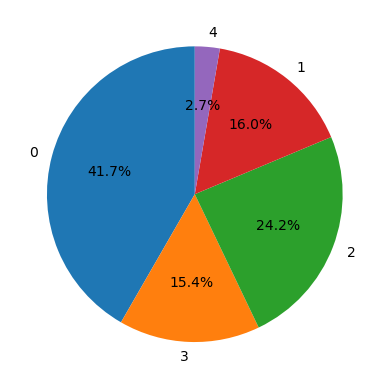

In [104]:
aux=Counter(train_df1["bracket"].tolist())
plt.pie(aux.values(),labels=aux.keys(),autopct='%1.1f%%', startangle=90)

As in the regression setting, different algorithms were tried to asses which is the most suited for the data at hand. This time though, the measurement used to perform the model evaluation was a simple accuracy. 

In [110]:
X_class = train_df1[[ 'danceability', 'energy', 'loudness',
       'acousticness', 'valence', 'tempo',
       'feature_max_artist_popularity', 'feature_mean_artist_popularity',
       'feature_max_artist_followers', 'feature_mean_artist_followers',
       'genre_flag_top', 'genre_flag_popular',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'release_month_1.0', 'release_month_2.0',
       'release_month_3.0', 'release_month_4.0', 'release_month_5.0',
       'release_month_6.0', 'release_month_7.0', 'release_month_8.0',
       'release_month_9.0', 'release_month_10.0', 'release_month_11.0',
       'release_month_12.0', 'release_month_nan', 'weekday_0.0', 'weekday_1.0',
       'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0',
       'weekday_6.0', 'weekday_nan', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness', 'log_followers']]
y_class = train_df1['bracket']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_class)
X_test = scaler.transform(X_test_class)
classifiers = [
    SVC(),
    RandomForestClassifier(),
    LogisticRegression()
]

for classifier in classifiers:
    classifier.fit(X_train_class, y_train_class)
    y_pred_class = classifier.predict(X_test_class)
    acc = accuracy_score(y_test_class, y_pred_class)
    print(f"{type(classifier).__name__}: Accuracy = {acc:.2f}")

SVC: Accuracy = 0.46
RandomForestClassifier: Accuracy = 0.58
LogisticRegression: Accuracy = 0.16


Once again, Random Forest seems to be the best performing algortihm on our data also in the classification setting. As of before, a GridSearchCV was applied to tune the hyperparameters of the model. In particular, this time a grid search was used instead of a RamdomizedSearchCV as the number of parameters to be tested was not so high and it was deemed appropriate, thus, to try all possible combinations. 

In [43]:
param_grid = {
    'n_estimators': [200,300,400,500],
    'max_depth': [None, 20, 25],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_class, y_train_class)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 2.3980815347721824,
                                                            1: 6.25,
                                                            2: 4.132231404958678,
                                                            3: 6.4935064935064934,
                                                            4: 37.03703703703704},
                                              max_depth=20, min_samples_split=4,
                                              n_estimators=500),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 20, 25],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [200, 300, 400, 500]},
             scoring='accuracy')

In [106]:
rfc=RandomForestClassifier(**grid_search.best_params_, class_weight = {0: 1/0.417, 1: 1/0.16, 2: 1/0.242, 3: 1/0.154, 4: 1/0.027},random_state=42)
rfc.fit(X_train_class, y_train_class)
y_pred_class = rfc.predict(X_test_class)
acc = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy = {acc:.2f}")

Accuracy = 0.59


Even after a 207 minutes grid search, the result did not improve much. Though, it has to be noted that accuracy is not always a proper measure to evaluate the performance pf a classification algorithm. Indeed, when unbalanced classes are present, a more suitable measure could be the ROC-AUC, which is obtained and plotted below:

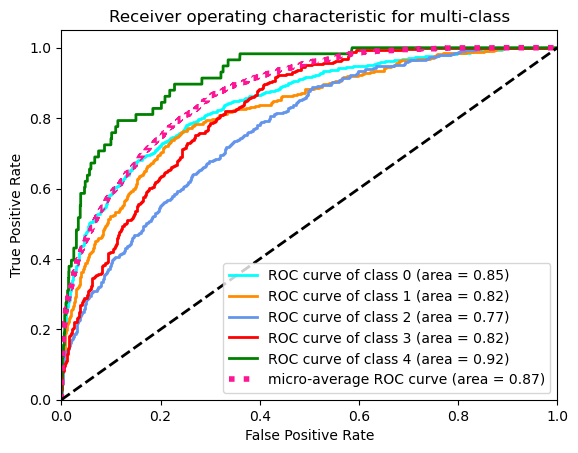

In [75]:
# Predict the probabilities for the testing set and binarize them
y_prob = rfc.predict_proba(X_test_class)
y_test_bin = label_binarize(y_test_class, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

# Then the false positive rate, true positive rate, and AUC was calculated for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# The micro-average ROC curve and ROC area were then computed
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

A ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. In the ROC curve, the diagonal line represents a random classifier that makes predictions at random. A classifier that performs better than random will have an ROC curve that is above the diagonal line. The farther the ROC curve is from the diagonal line, the better the classifier is performing. Then the Area Under Curve (AUC) provides an aggregate measure of performance across all possible classification thresholds. In particular, a random classifier would achieve an AUC of 0.5 while a perfect one an AUC of 1, thus the closer the AUC is to 1 the better the classifier is. In the case of multi-class classification, it is appropriate to plot the ROC curves for each class and also a micro-average ROC curve that aggregates the results across all classes so as to be able to evaluate the performance of the classifier not only on specific classes but also more in general. This way of assessing models performance might be more suitable for imbalanced classification problems as it does not only considers the basic accuracy of the algorithm but also the ability of the algorithm to correctly classify the minority classese. \
According to this measurement, the random forest seems to perform quite well, with an average AUC of 0.87 (remembering that 0.5 is the AUC of a random classifier while 1 is the AUC of a perfect classifier).

The same identical procedures have been applied for the case with only 4 classes. As it will be seen in the following, the results are quite similar. Indeed, raw accuracy increases by 3% but the AUC remains, on average, the same. Thus, classifying the songs into either 4 or 5 classes does not seem to make a big difference in terms of performance. Though, using 4 classes might be better for balance reasons. It has to be noted that attempts were made only for 4 and 5 classes as these are the ones that allow for an appropriate range of popularity scores to be included in each class. Indeed, if more classes were used, the range of popularity scores would have been too small and, hence, the classification would have been too difficult. On the other hand, using too few classes would have not yielded economically significant results that the record labels could possibly use before deciding into which songs to invest.

In [55]:
train_df1["bracket"]=[0 if 0<=x<25 else 1 for x in train_df1["popularity_song"]]     

In [56]:
for i in range(len(train_df1["bracket"])):
    if 50<=train_df1["popularity_song"][i] < 75:
        train_df1["bracket"][i] = 2
    elif 75<=train_df1["popularity_song"][i] <= 100:
        train_df1["bracket"][i] = 3


/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/2085123148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1["bracket"][i] = 3
/var/folders/hx/n0zcsqj95pq2sj7w5hfh23qm0000gn/T/ipykernel_70738/2085123148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df1["bracket"][i] = 2


([<matplotlib.patches.Wedge at 0x7fb5a4d7faf0>,
 [Text(-1.0835799999663938, 0.18935253806809826, '0'),
  Text(-0.2104619749142805, -1.0796785434170584, '3'),
  Text(0.7491811139682008, -0.8054363155913483, '1'),
  Text(0.7906630373091649, 0.7647561450770083, '2')],
 [Text(-0.5910436363453055, 0.10328320258259904, '44.5%'),
  Text(-0.11479744086233482, -0.5889155691365773, '4.9%'),
  Text(0.4086442439826549, -0.43932889941346265, '25.1%'),
  Text(0.4312707476231808, 0.41713971549654993, '25.5%')])

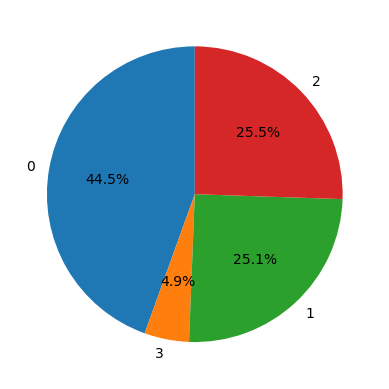

In [57]:
aux=Counter(train_df1["bracket"].tolist())
plt.pie(aux.values(),labels=aux.keys(),autopct='%1.1f%%', startangle=90)

In [59]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
X_class = train_df1[[ 'danceability', 'energy', 'loudness',
       'acousticness', 'valence', 'tempo',
       'feature_max_artist_popularity', 'feature_mean_artist_popularity',
       'feature_max_artist_followers', 'feature_mean_artist_followers',
       'genre_flag_top', 'genre_flag_popular',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'release_month_1.0', 'release_month_2.0',
       'release_month_3.0', 'release_month_4.0', 'release_month_5.0',
       'release_month_6.0', 'release_month_7.0', 'release_month_8.0',
       'release_month_9.0', 'release_month_10.0', 'release_month_11.0',
       'release_month_12.0', 'release_month_nan', 'weekday_0.0', 'weekday_1.0',
       'weekday_2.0', 'weekday_3.0', 'weekday_4.0', 'weekday_5.0',
       'weekday_6.0', 'weekday_nan', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness', 'log_followers']]
y_class = train_df1['bracket']
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_class)
X_test = scaler.transform(X_test_class)
classifiers = [
    SVC(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(),
    GaussianNB()
]

for classifier in classifiers:
    classifier.fit(X_train_class, y_train_class)
    y_pred_class = classifier.predict(X_test_class)
    acc = accuracy_score(y_test_class, y_pred_class)
    print(f"{type(classifier).__name__}: Accuracy = {acc:.2f}")

SVC: Accuracy = 0.48
RandomForestClassifier: Accuracy = 0.62
LogisticRegression: Accuracy = 0.24
SGDClassifier: Accuracy = 0.22
GaussianNB: Accuracy = 0.48


In [60]:
rfc=RandomForestClassifier(n_estimators=400, class_weight = {0: 1/0.445, 1: 1/0.251, 2: 1/0.255, 3: 1/0.049},random_state=42)
rfc.fit(X_train_class, y_train_class)
y_pred_class = rfc.predict(X_test_class)
acc = accuracy_score(y_test_class, y_pred_class)
print(f"Accuracy = {acc:.2f}")

Accuracy = 0.62


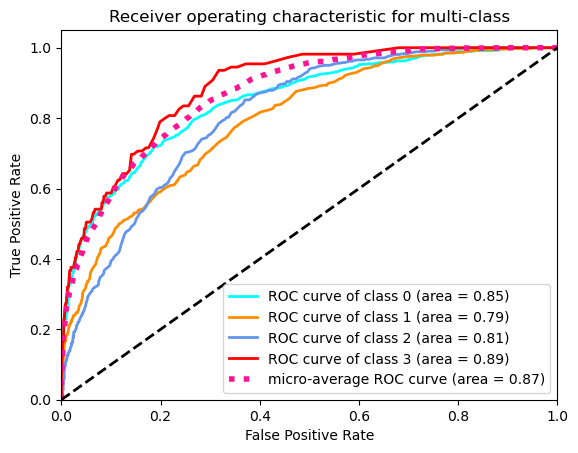

In [62]:
y_prob = rfc.predict_proba(X_test_class)
y_test_bin = label_binarize(y_test_class, classes=[0, 1, 2, 3])
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()